In [45]:
import scipy

In [46]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [47]:
## The main model file. Refer to the supplementary note 1 for the detailed equations.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
def HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_Lac, C_OPN, P):
## Load the parameters
    CST = y[0]                      # Killer T cell-exposed Tumor stem cell
    CSNT = y[1]                     # CAF-protected tumor stem cells 
    CNPDL1 = y[2]                   # Killer T cell-exposed PDL1+ tumor cell
    CPDL1 = y[3]                    # Killer T cell-exposed PDL1- tumor cell
    CRNPDL1 = y[4]                  # CAF protected PDL1- tumor cell
    CRPDL1 = y[5]                   # CAF protected PDL1- tumor cell
    Res = y[6]                      # Resource
    TKPD1 = y[7]                    # PD1+ (Programmed death) killer T cells
    TKNPD1 = y[8]                   # PD1 removed killer T cells
    TH = y[9]                       # Helper/ effector T cells
    TREG = y[10]                    # Regulatory T cells
    TEX = y[11]                     # Exhausted T cells  
    FWT = y[12]                     # Wild type fibroblasts
    CAF = y[13]                     # Invasive cancer associated fibroblasts
    MACM1 = y[14]                   # M1 macrophage
    MACM2 = y[15]                   # M2 macrophage
    IL2 = y[16]                     # Interleukin-2
    LIF = y[17]                     # Leukemia inhibitory factor
    IFNG = y[18]                    # Interferon gamma
    IL8 = y[19]                     # Interleukin-8
    LAC = y[20]                     # Lactate
    ICAM = y[21]                    # Intercellular adhesion modlecule 1
    OPN = y[22]                     # Osteopontin
    IRF8 = y[23]                    # Iterferon regulatory factor 8

# Parameters
    K_RCST, K_RCSNT, K_RCNPDL1, K_RCRNPDL1, K_RCPDL1, K_RCRPDL1, K_RIn, alpha_Comp, Y_CST, Y_CPDL1M, Y_RM, K_TXC, K_FWTC, K_CAFC, K_CAFCR, K_TKC, K_Lac, K_TKCIFNG, alpha, K_CAFB, K_CSTCNPDL1, K_CSTCPDL1, K_CPDNPD, K_CSTD, K_CNPDL1D, K_CPDL1D, K_ResD, Delta, Y_TKM, K_TKPD, K_TKNPD, K_TH, K_TREG, K_TEX, K_TKPDNPD1, K_TKPDTEX, K_THTK, K_IL2TK, K_CNPDT, K_CAFTREG, K_TREGTH, K_TKPDD, K_THD, K_TREGD, K_TEXD, Y_FWTM, K_FWT, K_CAF, K_OPNCAF, K_CTCAF, K_CTCAFR, K_LIF, K_LIFT, K_M2CAF, K_FWTCAF, K_CAFFWT, K_FWTD, K_CAFD, Y_MM, K_M1, K_M2, K_CANM1, K_M2M1, K_M1M2ICAM1, K_ICAM1, K_CAFM2, K_M1D, K_M2D, K_TIL2, K_IL2D, K_TIFNG, K_OPNIFNG, K_IFNGD, K_TICAM1, K_ICAM1D, K_CANOPN, K_CAFOPN, K_IRFOPN, K_OPND, K_CANLIF, K_CAFLIF, K_LIFD, K_CANIL8, K_CAFIL8, K_M2IL8, K_IL8D, K_M1IRF8, K_IRF8D, K_M2Lac, K_CANLac, K_LacD = P

## Hyper parameters
    I=np.tanh(alpha*K_CAFB*CAF)            

    alpha_T=np.exp(-Delta*alpha**2*CAF**2)  # Skin depth effect for infiltration of killer T cells into the proximity of tumor cells

## Population of cancer cell states

# T-exposed tumor stem cell

    F_ResCST=Res*K_RCST*CST*(1-CST/((1-I)*Y_CST+1))*1/(alpha_Comp*(CPDL1+CNPDL1)+1)        # Resource-driven proliferation of tumor stem cells

    F_TxCST=(1+K_TXC*TEX/(TEX+1))                                                          # Exhausted T-cells-driven proliferation modulator of tumor stem cells 

    F_CAFCST=(1+K_CAFC*CAF/(CAF+1))                                                        # OPN-driven proliferation modulator of tumor stem cells

    F_CSTCNPDL1= K_CSTCNPDL1*(IL8/(IL8+1))*CST                                             # Conversion from stem to non-PDL1, T-exposed tumor cells

    F_CSTCPDL1= K_CSTCPDL1*(IL8/(IL8+1))*CST                                               # Conversion from stem to PDL1, T-exposed tumor cells

    F_TKCST= K_TKC*(IFNG/(IFNG+1))*CST*(TKPD1+TKNPD1)*1/(K_Lac*LAC+1)

    F_DCST= K_CSTD*(1+IFNG/(IFNG+1)+MACM1/(MACM1+1))*CST                                   # Death of stem cells

    dydt_CST=F_ResCST*F_CAFCST*F_TxCST-F_TKCST-(F_CSTCNPDL1+F_CSTCPDL1)-F_DCST

# Non T_exposed Tumor Stem cell

    F_ResCSNT=Res*K_RCSNT*CSNT*(1-CSNT/(I*Y_CST+1))*1/(alpha_Comp*(CRPDL1+CRNPDL1)+1)      # Resource-driven proliferation of tumor stem cells

    F_CAFCSNT=(1+K_CAFCR*CAF/(1+CAF))                                                      # CAF-driven proliferation modulator of tumor stem cells

    F_TxCSNT=(1+K_TXC*TEX*alpha_T/(TEX+1))                                                 # Exhausted T-cells-driven proliferation modulator of tumor stem cells 

    F_TKCSNT= K_TKC*(IFNG/(IFNG+1))*CSNT*alpha_T*(TKPD1+TKNPD1)*1/(1+K_Lac*LAC)

    F_CSNTCRNPDL1=K_CSTCNPDL1*IL8/(IL8+1)*CSNT                                             # Conversion from stem to non-PDL1, non T-exposed tumor cells

    F_CSNTCRPDL1= K_CSTCPDL1*IL8/(IL8+1)*CSNT                                              # Conversion from stem to PDL1, non T-exposed tumor cells

    F_DCSNT= K_CSTD*(1+IFNG/(IFNG+1)+MACM1/(MACM1+1))*CSNT                                 # Death of stem cells

    dydt_CSNT=F_ResCSNT*F_CAFCSNT*F_TxCSNT-F_TKCSNT-(F_CSNTCRNPDL1+F_CSNTCRPDL1)-F_DCSNT

# PDL1-, T-exposed tumor cells

    F_ResCNPDL1= Res*K_RCNPDL1*CNPDL1*(1-CNPDL1/((1-I)*Y_CPDL1M+1))*1/(alpha_Comp*(CST+CPDL1)+1)  # Resource-driven proliferation of tumor stem cells

    F_CAFCNPDL1= (1+K_CAFC*CAF/(1+CAF))                                                         # CAF-based proliferation modulator of PDL1-ve tumor cells
 
    F_TKCNPDL1=  K_TKC*IFNG/(IFNG+1)*(TKPD1+TKNPD1)*CNPDL1*1/(1+LAC*K_Lac)                      # Killer T-cell driven death of PDL1-ve tumor cells

    F_CNPDL1CPDL1= K_CPDNPD*IFNG/(IFNG+1)*CNPDL1                                                # IFNG-induced conversion from PDL1-ve to +ve tumor cells

    F_DCNPDL1= K_CNPDL1D*CNPDL1                                                                 # Death of Non-PDL1, T-exposed tumor cells

    dydt_CNPDL1= F_ResCNPDL1*F_CAFCNPDL1*F_TxCST+F_CSTCNPDL1-F_TKCNPDL1-F_CNPDL1CPDL1-F_DCNPDL1

# PDL1+, T-exposed tumor cells

    F_ResCPDL1= Res*K_RCPDL1*CPDL1*(1-CPDL1/(Y_CPDL1M*(1-I)+1))*1/(alpha_Comp*(CST+CNPDL1)+1)   # Resource-driven proliferation of PDL1 +ve cells

    F_CAFCPDL1=(1+K_CAFC*CAF/(1 + CAF))                                                         # CAF-based proliferation modulator of PDL1+ve tumor cells

    F_TKNPDCPDL1=K_TKC*IFNG/(IFNG+1)*CPDL1*TKNPD1*1/(K_Lac*LAC+1)                               # Killer, PD1-ve T-cell driven death of PDL1+ve tumor cells

    F_DCPDL1= K_CPDL1D*CPDL1                                                                    # Death of PDL1, T-exposed tumor cells   

    dydt_CPDL1=F_ResCPDL1*F_CAFCPDL1*F_TxCST+F_CNPDL1CPDL1+F_CSTCPDL1-F_TKNPDCPDL1-F_DCPDL1

# PDL1-, non-T-exposed tumor cells 

    F_ResCRNPDL1=Res*K_RCRNPDL1*CRNPDL1*(1-CRNPDL1/(I*Y_CPDL1M+1))*1/(alpha_Comp*(CSNT+CRPDL1)+1) # Resource-driven proliferation of Non-PDL1, Non T-exposed tumor cells

    F_CAFCRNPDL1=(1+K_CAFCR*CAF/(1 + CAF))                                                      # CAF-based proliferation modulator of Non-PDL1, Non T-exposed PDL1+ve tumor cells

    F_TKCRNPDL1= K_TKC*IFNG/(IFNG+1)*alpha_T*(TKPD1+TKNPD1)*CRNPDL1*1/(K_Lac*LAC+1)             # Killer T-cell driven death of PDL1-ve tumor cells

    F_CRNPDL1CRPDL1=  K_CPDNPD*IFNG/(IFNG+1)*CRNPDL1                                            # ING-induced conversion from PDL1-ve to +ve tumor cells

    F_DCRNPDL1= K_CNPDL1D*CRNPDL1    

    dydt_CRNPDL1= F_ResCRNPDL1*F_CAFCRNPDL1*F_TxCSNT+F_CSNTCRNPDL1-F_TKCRNPDL1-F_CRNPDL1CRPDL1-F_DCRNPDL1

# PDL1+, non T-exposed tumor cells

    F_ResCRPDL1= Res*K_RCRPDL1*CRPDL1*(1-CRPDL1/(I*Y_CPDL1M+1))*1/(alpha_Comp*(CSNT+CNPDL1)+1)     # Resource-driven proliferation of Non-PDL1, Non T-exposed tumor cells

    F_CAFCRPDL1=(1+K_CAFCR*CAF/(1 + CAF))                                                        # CAF-based proliferation modulator of PDL1+ve tumor cells

    F_TKNPDCRPDL1= K_TKC*IFNG/(IFNG+1)*TKNPD1*CRPDL1*1/(LAC*K_Lac+1)*alpha_T                     # Killer, PD1-ve T-cell driven death of PDL1+ve tumor cells

    F_DCRPDL1= K_CPDL1D*CRPDL1                                                                   # Death of PDL1, T-exposed tumor cells   

    dydt_CRPDL1=F_ResCRPDL1*F_CAFCRPDL1*F_TxCSNT+F_CRNPDL1CRPDL1+F_CSNTCRPDL1-F_TKNPDCRPDL1-F_DCRPDL1

## Resource concentration

    F_ProRes=K_RIn*(Y_RM-Res)                                                                      # production= Constant resource rate

    F_DRes= K_ResD*Res                                                                             # Degradation 

    dydt_Res=F_ProRes-F_DRes                                 

## T-cell population

# Killer PD1+ T cells

    F_ProTKPD1=K_TKPD*TKPD1*(1-TKPD1/(Y_TKM-TEX-TKNPD1+1))                                   # Proliferation of killer, PD1+ve T-cells

    F_THTKPD1=(1+K_THTK*(TH*MACM1)/(TH*MACM1+1))                                           # T-Helper-driven proliferation modulator of Killer, PD1+ve T cells

    F_IL2TKPD1=(1+K_IL2TK*IL2/(1+IL2))                                                     # IL2-driven proliferation modulator of Killer, PD1+ve T cells

    F_TKPD1TKNPD1= K_TKPDNPD1*u*TKPD1                                                      # ICI-based conversion from PD1+ve to -ve killer T cells

    F_TKPD1TEX=K_TKPDTEX*TKPD1*(CPDL1*MACM2)/(CPDL1*MACM2+1)                               # PDL1+ve and M2 driven conversion of PD1+ve to exhausted T cells  

    F_DTKPD1= K_TKPDD*TKPD1                                                                # Death rate of PD1+, killer T cells

    dydt_TKPD1 = F_ProTKPD1*F_THTKPD1*F_IL2TKPD1 - F_TKPD1TKNPD1 - F_TKPD1TEX - F_DTKPD1 

# Killer PD1- T cells

    F_ProTKNPD1=K_TKNPD*TKNPD1*u*(1-TKNPD1/(Y_TKM-TEX-TKPD1+1))                            # Proliferation of killer, PD1+ve T-cells

    F_THTKNPD1=(1+u*K_THTK*TH/(TH+1))                                                      # T-Helper-driven proliferation modulator of Killer, PD1+ve T cells

    F_IL2TKNPD1=(1+K_IL2TK*IL2/(1+IL2))                                                    # IL2-driven proliferation modulator of Killer, PD1+ve T cells

    F_DTKNPD1= K_TKPDD*TKNPD1

    dydt_TKNPD1=F_ProTKNPD1*F_THTKNPD1*F_IL2TKNPD1+F_TKPD1TKNPD1-F_DTKNPD1

# Helper T cells

    F_ProTH=K_TH*TH*(1-TH/Y_TKM)                                                           # Proliferation of helper T-cells

    F_CNPDL1TH=(1+K_CNPDT*(CNPDL1+u*CPDL1)/(CNPDL1+u*CPDL1+1))                             # PDL1-ve tumor cell-driven proliferation modulator of helper T cells

    F_TREGTH=1/(1+K_TREGTH*TREG)                                                           # Regulatory T cell-driven regulation of helper T cell population

    F_DTH=K_THD*TH                                                                         # Death rate of Helper T cells

    dydt_TH=F_ProTH*F_CNPDL1TH*F_TREGTH-F_DTH

# Regulatory T cells

    F_ProTREG=K_TREG*TREG*(1-TREG/Y_TKM)                                                   # Proliferation of regulatory T cells

    F_CAFTREG=(1+K_CAFTREG*CAF/(1+CAF))                                                    # CAF-driven proliferation of regulatory T cells                  

    F_DTREG=K_TREGD*TREG                                                                   # Death rate of Regulatory T cells

    dydt_TREG=F_ProTREG*F_CAFTREG-F_DTREG

# Exhausted T cells

    F_ProTEX=K_TEX*TEX*(1-TEX/(Y_TKM-TKPD1-TKNPD1+1))                                      # Natural Proliferation rate of exhausted T cells

    F_DTEX=K_TEXD*TEX                                                                      # Death rate of exhausted T cells

    dydt_TEX=F_ProTEX+F_TKPD1TEX-F_DTEX

## Fibroblasts population

# Wild type

    F_ProFWT=K_FWT*FWT*(1-FWT/(Y_FWTM-CAF+1))                                              # Proliferation of Wild-type fibroblasts

    F_CAFFWT=K_CAFFWT*CAF                                                                  # Conversion from CAF to wild type fibroblasts

    F_FWTCAF=K_FWTCAF*(K_LIF*LIF)**2/((K_LIF*LIF)**2+K_LIFT)*FWT                           # LIF-driven conversion from wild type fibroblasts to CAF

    F_DFWT=K_FWTD*FWT                                                                      # Death rate of wild type fibroblast

    dydt_FWT=F_ProFWT-F_FWTCAF+F_CAFFWT-F_DFWT


# Invasive

    F_ProCAF=K_CAF*CAF*(1-CAF/(Y_FWTM-FWT+1))                                             # Proliferation of CAFs

    F_OPNCAF=(1+K_OPNCAF*OPN/(1+OPN))                                                     # OPN-driven proliferation modulator of CAFs

    F_M2CAF= (1+K_M2CAF*MACM2/(1+MACM2))                                                  # OPN-driven proliferation modulator of CAFs

    F_CANCAF=(1+K_CTCAF*((CST+CNPDL1+CPDL1)/(1+CST+CNPDL1+CPDL1)+K_CTCAFR*(CSNT+CRNPDL1+CRPDL1)/(1+CSNT+CRNPDL1+CRPDL1))) # CAF-tumor cell paracrine interactions

    F_DCAF=K_CAFD*CAF                                                                     # Death rate of cancer associated fibroblasts

    dydt_CAF=F_ProCAF*F_OPNCAF*F_OPNCAF*F_M2CAF*F_CANCAF+F_FWTCAF-F_CAFFWT-F_DCAF

## Macrophages

# M1 phase

    F_ProMACM1= K_M1*MACM1*(1-MACM1/(Y_MM-MACM2+1))                                        # Proliferation of M1 macrophage

    F_CANM1= (1+K_CANM1)*(CNPDL1+u*CPDL1+CST+CSNT+u*CRPDL1+CRNPDL1)/(CNPDL1+u*CPDL1+CST+CSNT+u*CRPDL1+CRNPDL1+1) # M1 macrophage activation due to the antigen presenting cells

    F_M1M2= K_M1M2ICAM1*MACM1*(K_ICAM1*ICAM)**2/((K_ICAM1*ICAM)**2+1);                       # Lactate-driven Conversion from M1 to M2 macrophage

    F_M2M1= K_M2M1*MACM2;                                                                  # Conversion from M2 to M1 macrophage

    F_DMACM1= K_M1D*MACM1;                                                                 # Death rate of M1 macrophage

    dydt_MACM1=F_ProMACM1*F_CANM1+F_M2M1-F_M1M2-F_DMACM1

# M2 phase

    F_ProMACM2=K_M2*MACM2*(1-MACM2/(Y_MM-MACM1+1))                                         # Proliferation of M2 macrophage

    F_CAFMACM2=(1+K_CAFM2*CAF/(CAF+1))                                                     # CAF-TAM paracrine interaction

    F_DMACM2= K_M2D*MACM2                                                                  # Death rate of M2 macrophage

    dydt_MACM2= F_ProMACM2*F_CAFMACM2+F_M1M2-F_M2M1-F_DMACM2

## Cytokines concentration

# Interleukin 2

    F_TKIL2=K_TIL2*(TKPD1+TKNPD1)                                                         # Killer T-cells secretion of IL-2

    F_CIL2=C_IL2                                                                          # IL-2 injection

    F_DIL2=K_IL2D*IL2                                                                     # Degradation rate of IL2

    dydt_IL2=F_CIL2+F_TKIL2-F_DIL2

# Lukemia Inhibiting Factor (IL6)

    F_CANLIF=(CST+CSNT+CNPDL1+CPDL1+CRNPDL1+CRPDL1)*K_CANLIF                              # CAF secretion of LIF

    F_CAFLIF=(CAF)*K_CAFLIF                                                               # IFNG-driven inhibition of LIF

    F_DLIF=K_LIFD*LIF                                                                     # Death rate of LIF

    F_LIFKnock=C_LIF*LIF                                                                  # External inhibition of LIF 

    dydt_LIF=F_CAFLIF+F_CANLIF-F_DLIF-F_LIFKnock


# Interferon Gamma

    F_TKIFN=K_TIFNG*(TKPD1+TKNPD1)                                                        # Killer T-cell secretion of IFNG

    F_OPNIFN=1/(OPN*K_OPNIFNG+1)                                                          # OPN-driven inhibition of IFNG

    F_DIFNG=K_IFNGD*IFNG                                                                  # Death rate of IFNG

    dydt_IFNG=F_TKIFN*F_OPNIFN-F_DIFNG

# Interleukin 8

    F_CAFIL8= K_CAFIL8*CAF                                                                # CAF secretion of IL-8

    F_CANIL8= K_CANIL8*(CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)                             # IL-8 secretion from Tumor cells 

    F_M2IL8=  K_M2IL8*MACM2                                                               # IL-8 secretion from M2 macrophage

    F_DIL8=K_IL8D*IL8                                                                     # Death rate of IL-8

    F_IL8Knock= C_IL8*IL8                                                                 # External knockpout of IL-8

    dydt_IL8=F_CAFIL8+F_CANIL8+F_M2IL8-F_IL8Knock-F_DIL8

# Lactate

    F_CANLac=  (CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)*K_CANLac                           # Tumor cells secretion of Lactate

    F_MACLac=  K_M2Lac*MACM2                                                             # M2 macrophage secretion of Lactate

    F_LacKnock= C_Lac*LAC                                                                # External inhibition of lactate

    F_DLAC= K_LacD*LAC                                                                   # Death rate of LAC

    dydt_LAC=F_CANLac+F_MACLac-F_LacKnock-F_DLAC

# Intercellular Adhesion Molecule

    F_TKICAM=K_TICAM1*(TKPD1+TKNPD1)                                                     # T cell-based secretion of ICMA

    F_DICAM= K_ICAM1D*ICAM                                                               # Death rate of ICAM

    dydt_ICAM= F_TKICAM-F_DICAM

# Osteopontin

    F_CAFOPN=K_CAFOPN*CAF                                                                # CAF secretion of OPN

    F_CANOPN=K_CANOPN*(CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)                             # Tumor cells secretion of OPN

    F_IRF8OPN=1/(K_IRFOPN*IRF8+1)                                                        # IRF8-based inhibition of OPN

    F_DOPN=K_OPND*OPN                                                                    # Degradation rate of OPN

    F_OPNKnock=C_OPN*OPN                                                                 # External inhibition of OPN

    dydt_OPN=(F_CAFOPN+F_CANOPN)*F_IRF8OPN-F_DOPN-F_OPNKnock

# Interferon Regulatory Factor 8

    F_MACM1IRF8=K_M1IRF8*MACM1                                                            # M1 macrophage secretion of IRF8

    F_DIRF8=K_IRF8D*IRF8                                                                  # Degradation rate of IRF8

    dydt_IRF8= F_MACM1IRF8-F_DIRF8

# Overall reaction    
    return [dydt_CST, dydt_CSNT, dydt_CNPDL1, dydt_CPDL1, dydt_CRNPDL1, dydt_CRPDL1, dydt_Res, dydt_TKPD1, dydt_TKNPD1, dydt_TH, dydt_TREG, dydt_TEX, dydt_FWT, dydt_CAF, dydt_MACM1, dydt_MACM2, dydt_IL2, dydt_LIF, dydt_IFNG, dydt_IL8, dydt_LAC, dydt_ICAM, dydt_OPN, dydt_IRF8]

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def HNSCC_mod_Res_Comp(t, y, u, C_IL2, C_LIF, C_IL8, C_Lac, C_OPN, P):
## Load the parameters
    CST = y[0]
    CSNT = y[1]
    CNPDL1 = y[2]
    CPDL1 = y[3]
    CRNPDL1 = y[4] 
    CRPDL1 = y[5] 
    Res = y[6]
    TKPD1 = y[7]
    TKNPD1 = y[8]
    TH = y[9]
    TREG = y[10]
    TEX = y[11]
    FWT = y[12]
    CAF = y[13]
    MACM1 = y[14]
    MACM2 = y[15]
    IL2 = y[16]
    LIF = y[17]
    IFNG = y[18]
    IL8 = y[19]
    LAC = y[20]
    ICAM = y[21]
    OPN = y[22]
    IRF8 = y[23]
## Resource to cancer cells

    K_RCST, K_RCSNT, K_RCNPDL1, K_RCRNPDL1, K_RCPDL1, K_RCRPDL1, K_RIn, alpha_Comp, Y_CST, Y_CPDL1M, Y_RM, K_TXC, K_FWTC, K_CAFC, K_CAFCR, K_TKC, K_Lac, K_TKCIFNG, alpha, K_CAFB, K_CSTCNPDL1, K_CSTCPDL1, K_CPDNPD, K_CSTD, K_CNPDL1D, K_CPDL1D, K_ResD, Delta, Y_TKM, K_TKPD, K_TKNPD, K_TH, K_TREG, K_TEX, K_TKPDNPD1, K_TKPDTEX, K_THTK, K_IL2TK, K_CNPDT, K_CAFTREG, K_TREGTH, K_TKPDD, K_THD, K_TREGD, K_TEXD, Y_FWTM, K_FWT, K_CAF, K_OPNCAF, K_CTCAF, K_CTCAFR, K_LIF, K_LIFT, K_M2CAF, K_FWTCAF, K_CAFFWT, K_FWTD, K_CAFD, Y_MM, K_M1, K_M2, K_CANM1, K_M2M1, K_M1M2ICAM1, K_ICAM1, K_CAFM2, K_M1D, K_M2D, K_TIL2, K_IL2D, K_TIFNG, K_OPNIFNG, K_IFNGD, K_TICAM1, K_ICAM1D, K_CANOPN, K_CAFOPN, K_IRFOPN, K_OPND, K_CANLIF, K_CAFLIF, K_LIFD, K_CANIL8, K_CAFIL8, K_M2IL8, K_IL8D, K_M1IRF8, K_IRF8D, K_M2Lac, K_CANLac, K_LacD = P

## Hyper parameters
    I=np.tanh(alpha*K_CAFB*CAF)

    alpha_T=np.exp(-Delta*alpha**2*CAF**2)

## Population of cancer cell states

# T-exposed tumor stem cell

    F_ResCST=Res*K_RCST*CST*(1-CST/((1-I)*Y_CST+1))*1/(alpha_Comp*(CPDL1+CNPDL1)+1)        # Resource-driven proliferation of tumor stem cells

    F_TxCST=(1+K_TXC*TEX/(TEX+1))                                                          # Exhausted T-cells-driven proliferation modulator of tumor stem cells 

    F_CAFCST=(1+K_CAFC*CAF/(CAF+1))                                                        # OPN-driven proliferation modulator of tumor stem cells

    F_CSTCNPDL1= K_CSTCNPDL1*(IL8/(IL8+1))*CST                                             # Conversion from stem to non-PDL1, T-exposed tumor cells

    F_CSTCPDL1= K_CSTCPDL1*(IL8/(IL8+1))*CST                                               # Conversion from stem to PDL1, T-exposed tumor cells

    F_TKCST= K_TKC*(IFNG/(IFNG+1))*CST*(TKPD1+TKNPD1)*1/(K_Lac*LAC+1)

    F_DCST= K_CSTD*(1+IFNG/(IFNG+1)+MACM1/(MACM1+1))*CST                                   # Death of stem cells

    dydt_CST=F_ResCST*F_CAFCST*F_TxCST-F_TKCST-(F_CSTCNPDL1+F_CSTCPDL1)-F_DCST

# Non T_exposed Tumor Stem cell

    F_ResCSNT=Res*K_RCSNT*CSNT*(1-CSNT/(I*Y_CST+1))*1/(alpha_Comp*(CRPDL1+CRNPDL1)+1)      # Resource-driven proliferation of tumor stem cells

    F_CAFCSNT=(1+K_CAFCR*CAF/(1+CAF))                                                      # CAF-driven proliferation modulator of tumor stem cells

    F_TxCSNT=(1+K_TXC*TEX*alpha_T/(TEX+1))                                                 # Exhausted T-cells-driven proliferation modulator of tumor stem cells 

    F_TKCSNT= K_TKC*(IFNG/(IFNG+1))*CSNT*alpha_T*(TKPD1+TKNPD1)*1/(1+K_Lac*LAC)

    F_CSNTCRNPDL1=K_CSTCNPDL1*IL8/(IL8+1)*CSNT                                             # Conversion from stem to non-PDL1, non T-exposed tumor cells

    F_CSNTCRPDL1= K_CSTCPDL1*IL8/(IL8+1)*CSNT                                              # Conversion from stem to PDL1, non T-exposed tumor cells

    F_DCSNT= K_CSTD*(1+IFNG/(IFNG+1)+MACM1/(MACM1+1))*CSNT                                 # Death of stem cells

    dydt_CSNT=F_ResCSNT*F_CAFCSNT*F_TxCSNT-F_TKCSNT-(F_CSNTCRNPDL1+F_CSNTCRPDL1)-F_DCSNT

# PDL1-, T-exposed tumor cells

    F_ResCNPDL1= Res*K_RCNPDL1*CNPDL1*(1-CNPDL1/((1-I)*Y_CPDL1M+1))*1/(alpha_Comp*(CST+CPDL1)+1)  # Resource-driven proliferation of tumor stem cells

    F_CAFCNPDL1= (1+K_CAFC*CAF/(1+CAF))                                                         # CAF-based proliferation modulator of PDL1-ve tumor cells
 
    F_TKCNPDL1=  K_TKC*IFNG/(IFNG+1)*(TKPD1+TKNPD1)*CNPDL1*1/(1+LAC*K_Lac)                      # Killer T-cell driven death of PDL1-ve tumor cells

    F_CNPDL1CPDL1= K_CPDNPD*IFNG/(IFNG+1)*CNPDL1                                                # IFNG-induced conversion from PDL1-ve to +ve tumor cells

    F_DCNPDL1= K_CNPDL1D*CNPDL1                                                                 # Death of Non-PDL1, T-exposed tumor cells

    dydt_CNPDL1= F_ResCNPDL1*F_CAFCNPDL1*F_TxCST+F_CSTCNPDL1-F_TKCNPDL1-F_CNPDL1CPDL1-F_DCNPDL1

# PDL1+, T-exposed tumor cells

    F_ResCPDL1= Res*K_RCPDL1*CPDL1*(1-CPDL1/(Y_CPDL1M*(1-I)+1))*1/(alpha_Comp*(CST+CNPDL1)+1)   # Resource-driven proliferation of PDL1 +ve cells

    F_CAFCPDL1=(1+K_CAFC*CAF/(1 + CAF))                                                         # CAF-based proliferation modulator of PDL1+ve tumor cells

    F_TKNPDCPDL1=K_TKC*IFNG/(IFNG+1)*CPDL1*TKNPD1*1/(K_Lac*LAC+1)                               # Killer, PD1-ve T-cell driven death of PDL1+ve tumor cells

    F_DCPDL1= K_CPDL1D*CPDL1                                                                    # Death of PDL1, T-exposed tumor cells   

    dydt_CPDL1=F_ResCPDL1*F_CAFCPDL1*F_TxCST+F_CNPDL1CPDL1+F_CSTCPDL1-F_TKNPDCPDL1-F_DCPDL1

# PDL1-, non-T-exposed tumor cells 

    F_ResCRNPDL1=Res*K_RCRNPDL1*CRNPDL1*(1-CRNPDL1/(I*Y_CPDL1M+1))*1/(alpha_Comp*(CSNT+CRPDL1)+1) # Resource-driven proliferation of Non-PDL1, Non T-exposed tumor cells

    F_CAFCRNPDL1=(1+K_CAFCR*CAF/(1 + CAF))                                                      # CAF-based proliferation modulator of Non-PDL1, Non T-exposed PDL1+ve tumor cells

    F_TKCRNPDL1= K_TKC*IFNG/(IFNG+1)*alpha_T*(TKPD1+TKNPD1)*CRNPDL1*1/(K_Lac*LAC+1)             # Killer T-cell driven death of PDL1-ve tumor cells

    F_CRNPDL1CRPDL1=  K_CPDNPD*IFNG/(IFNG+1)*CRNPDL1                                            # ING-induced conversion from PDL1-ve to +ve tumor cells

    F_DCRNPDL1= K_CNPDL1D*CRNPDL1    

    dydt_CRNPDL1= F_ResCRNPDL1*F_CAFCRNPDL1*F_TxCSNT+F_CSNTCRNPDL1-F_TKCRNPDL1-F_CRNPDL1CRPDL1-F_DCRNPDL1

# PDL1+, non T-exposed tumor cells

    F_ResCRPDL1= Res*K_RCRPDL1*CRPDL1*(1-CRPDL1/(I*Y_CPDL1M+1))*1/(alpha_Comp*(CSNT+CNPDL1)+1)     # Resource-driven proliferation of Non-PDL1, Non T-exposed tumor cells

    F_CAFCRPDL1=(1+K_CAFCR*CAF/(1 + CAF))                                                        # CAF-based proliferation modulator of PDL1+ve tumor cells

    F_TKNPDCRPDL1= K_TKC*IFNG/(IFNG+1)*TKNPD1*CRPDL1*1/(LAC*K_Lac+1)*alpha_T                     # Killer, PD1-ve T-cell driven death of PDL1+ve tumor cells

    F_DCRPDL1= K_CPDL1D*CRPDL1                                                                   # Death of PDL1, T-exposed tumor cells   

    dydt_CRPDL1=F_ResCRPDL1*F_CAFCRPDL1*F_TxCSNT+F_CRNPDL1CRPDL1+F_CSNTCRPDL1-F_TKNPDCRPDL1-F_DCRPDL1

## Resource concentration

    F_ProRes=K_RIn*(Y_RM-Res)

    F_ConRes=20*(CST+CNPDL1+CPDL1+CRNPDL1+CRPDL1)*Res

    F_DRes= K_ResD*Res

    dydt_Res=F_ProRes-F_DRes-F_ConRes

## T-cell population

# Killer PD1+ T cells

    F_ProTKPD1=K_TKPD*TKPD1*(1-TKPD1/(Y_TKM-TEX-TKNPD1+1))                                   # Proliferation of killer, PD1+ve T-cells

    F_THTKPD1=(1+K_THTK*(TH*MACM1)/(TH*MACM1+1))                                           # T-Helper-driven proliferation modulator of Killer, PD1+ve T cells

    F_IL2TKPD1=(1+K_IL2TK*IL2/(1+IL2))                                                     # IL2-driven proliferation modulator of Killer, PD1+ve T cells

    F_TKPD1TKNPD1= K_TKPDNPD1*u*TKPD1                                                      # ICI-based conversion from PD1+ve to -ve killer T cells

    F_TKPD1TEX=K_TKPDTEX*TKPD1*(CPDL1*MACM2)/(CPDL1*MACM2+1)                               # PDL1+ve and M2 driven conversion of PD1+ve to exhausted T cells  

    F_DTKPD1= K_TKPDD*TKPD1                                                                # Death rate of PD1+, killer T cells

    dydt_TKPD1 = F_ProTKPD1*F_THTKPD1*F_IL2TKPD1 - F_TKPD1TKNPD1 - F_TKPD1TEX - F_DTKPD1 

# Killer PD1- T cells

    F_ProTKNPD1=K_TKNPD*TKNPD1*u*(1-TKNPD1/(Y_TKM-TEX-TKPD1+1))                            # Proliferation of killer, PD1+ve T-cells

    F_THTKNPD1=(1+u*K_THTK*TH/(TH+1))                                                      # T-Helper-driven proliferation modulator of Killer, PD1+ve T cells

    F_IL2TKNPD1=(1+K_IL2TK*IL2/(1+IL2))                                                    # IL2-driven proliferation modulator of Killer, PD1+ve T cells

    F_DTKNPD1= K_TKPDD*TKNPD1

# dydt_TKNPD1=F_TKPD1TKNPD1-F_DTKNPD1

    dydt_TKNPD1=F_ProTKNPD1*F_THTKNPD1*F_IL2TKNPD1+F_TKPD1TKNPD1-F_DTKNPD1

# Helper T cells

    F_ProTH=K_TH*TH*(1-TH/Y_TKM)                                                           # Proliferation of helper T-cells

    F_CNPDL1TH=(1+K_CNPDT*(CNPDL1+u*CPDL1)/(CNPDL1+u*CPDL1+1))                             # PDL1-ve tumor cell-driven proliferation modulator of helper T cells

    F_TREGTH=1/(1+K_TREGTH*TREG)                                                           # Regulatory T cell-driven regulation of helper T cell population

    F_DTH=K_THD*TH                                                                         # Death rate of Helper T cells

    dydt_TH=F_ProTH*F_CNPDL1TH*F_TREGTH-F_DTH

# Regulatory T cells

    F_ProTREG=K_TREG*TREG*(1-TREG/Y_TKM)                                                   # Proliferation of regulatory T cells

    F_CAFTREG=(1+K_CAFTREG*CAF/(1+CAF))                                                    # CAF-driven proliferation of regulatory T cells                  

    F_DTREG=K_TREGD*TREG                                                                   # Death rate of Regulatory T cells

    dydt_TREG=F_ProTREG*F_CAFTREG-F_DTREG

# Exhausted T cells

    F_ProTEX=K_TEX*TEX*(1-TEX/(Y_TKM-TKPD1-TKNPD1+1))

    F_DTEX=K_TEXD*TEX                                                                      # Death rate of exhausted t cells

    dydt_TEX=F_ProTEX+F_TKPD1TEX-F_DTEX

## Fibroblasts population

# Wild type

    F_ProFWT=K_FWT*FWT*(1-FWT/(Y_FWTM-CAF+1))                                              # Proliferation of Wild-type fibroblasts

    F_CAFFWT=K_CAFFWT*CAF                                                                  # Conversion from CAF to wild type fibroblasts

    F_FWTCAF=K_FWTCAF*(K_LIF*LIF)**2/((K_LIF*LIF)**2+K_LIFT)*FWT                             # LIF-driven conversion from wild type fibroblasts to CAF

    F_DFWT=K_FWTD*FWT                                                                      # Death rate of wild type fibroblast

    dydt_FWT=F_ProFWT-F_FWTCAF+F_CAFFWT-F_DFWT


# Invasive

    F_ProCAF=K_CAF*CAF*(1-CAF/(Y_FWTM-FWT+1))                                             # Proliferation of CAFs

    F_OPNCAF=(1+K_OPNCAF*OPN/(1+OPN))                                                     # OPN-driven proliferation modulator of CAFs

    F_M2CAF= (1+K_M2CAF*MACM2/(1+MACM2))                                                  # OPN-driven proliferation modulator of CAFs

    F_CANCAF=(1+K_CTCAF*((CST+CNPDL1+CPDL1)/(1+CST+CNPDL1+CPDL1)+K_CTCAFR*(CSNT+CRNPDL1+CRPDL1)/(1+CSNT+CRNPDL1+CRPDL1)))

    F_DCAF=K_CAFD*CAF                                                                     # Death rate of cancer associated fibroblasts

    dydt_CAF=F_ProCAF*F_OPNCAF*F_OPNCAF*F_M2CAF*F_CANCAF+F_FWTCAF-F_CAFFWT-F_DCAF

## Macrophages

# M1 phase

    F_ProMACM1= K_M1*MACM1*(1-MACM1/(Y_MM-MACM2+1))                                        # Proliferation of M1 macrophage

    F_CANM1= (1+K_CANM1)*(CNPDL1+u*CPDL1+CST+CSNT+u*CRPDL1+CRNPDL1)/(CNPDL1+u*CPDL1+CST+CSNT+u*CRPDL1+CRNPDL1+1)

    F_M1M2= K_M1M2ICAM1*MACM1*(K_ICAM1*ICAM)**2/((K_ICAM1*ICAM)**2+1);                       # Lactate-driven Conversion from M1 to M2 macrophage

    F_M2M1= K_M2M1*MACM2;                                                                  # Conversion from M2 to M1 macrophage

    F_DMACM1= K_M1D*MACM1;                                                                 # Death rate of M1 macrophage

    dydt_MACM1=F_ProMACM1*F_CANM1+F_M2M1-F_M1M2-F_DMACM1

# M2 phase

    F_ProMACM2=K_M2*MACM2*(1-MACM2/(Y_MM-MACM1+1))                                         # Proliferation of M2 macrophage

    F_CAFMACM2=(1+K_CAFM2*CAF/(CAF+1))

    F_DMACM2= K_M2D*MACM2                                                                  # Death rate of M2 macrophage

    dydt_MACM2= F_ProMACM2*F_CAFMACM2+F_M1M2-F_M2M1-F_DMACM2

## Cytokines concentration

# Interleukin 2

    F_TKIL2=K_TIL2*(TKPD1+TKNPD1)                                                         # Killer T-cells secretion of IL-2

    F_CIL2=C_IL2                                                                          # IL-2 injection

    F_DIL2=K_IL2D*IL2                                                                     # Degradation rate of IL2

    dydt_IL2=F_CIL2+F_TKIL2-F_DIL2

# Lukemia Inhibiting Factor (IL6)

    F_CANLIF=(CST+CSNT+CNPDL1+CPDL1+CRNPDL1+CRPDL1)*K_CANLIF                              # CAF secretion of LIF

    F_CAFLIF=(CAF)*K_CAFLIF                                                               # IFNG-driven inhibition of LIF

    F_DLIF=K_LIFD*LIF                                                                     # Death rate of LIF

    F_LIFKnock=C_LIF*LIF

    dydt_LIF=F_CAFLIF+F_CANLIF-F_DLIF-F_LIFKnock


# Interferon Gamma

    F_TKIFN=K_TIFNG*(TKPD1+TKNPD1)                                                        # Killer T-cell secretion of IFNG

    F_OPNIFN=1/(OPN*K_OPNIFNG+1)                                                          # OPN-driven inhibition of IFNG

    F_DIFNG=K_IFNGD*IFNG                                                                  # Death rate of IFNG

    dydt_IFNG=F_TKIFN*F_OPNIFN-F_DIFNG

# Interleukin 8

    F_CAFIL8= K_CAFIL8*CAF                                                                # CAF secretion of IL-8

    F_CANIL8= K_CANIL8*(CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)

    F_M2IL8=  K_M2IL8*MACM2

    F_DIL8=K_IL8D*IL8                                                                     # Death rate of IL-8

    F_IL8Knock= C_IL8*IL8

    dydt_IL8=F_CAFIL8+F_CANIL8+F_M2IL8-F_IL8Knock-F_DIL8

# Lactate

    F_CANLac=  (CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)*K_CANLac                           # Tumor cells secretion of Lactate

    F_MACLac=  K_M2Lac*MACM2                                                             # M2 macrophage secretion of Lactate

    F_LacKnock= C_Lac*LAC

    F_DLAC= K_LacD*LAC                                                                   # Death rate of LAC

    dydt_LAC=F_CANLac+F_MACLac-F_LacKnock-F_DLAC

# Intercellular Adhesion Molecule

    F_TKICAM=K_TICAM1*(TKPD1+TKNPD1)                                                     # T cell-based secretion of ICMA

    F_DICAM= K_ICAM1D*ICAM                                                               # Death rate of ICMA

    dydt_ICAM= F_TKICAM-F_DICAM

# Osteopontin

    F_CAFOPN=K_CAFOPN*CAF                                                                # CAF secretion of OPN

    F_CANOPN=K_CANOPN*(CST+CSNT+CPDL1+CNPDL1+CRPDL1+CRNPDL1)                             # Tumor cells secretion of OPN

    F_IRF8OPN=1/(K_IRFOPN*IRF8+1)                                                        # IRF8-based inhibition of OPN

    F_DOPN=K_OPND*OPN                                                                    # Degradation rate of OPN

    F_OPNKnock=C_OPN*OPN

    dydt_OPN=(F_CAFOPN+F_CANOPN)*F_IRF8OPN-F_DOPN-F_OPNKnock

# Interferon Regulatory Factor 8

    F_MACM1IRF8=K_M1IRF8*MACM1                                                            # M1 macrophage secretion of IRF8

    F_DIRF8=K_IRF8D*IRF8                                                                  # Degradation rate of IRF8

    dydt_IRF8= F_MACM1IRF8-F_DIRF8
    return [dydt_CST, dydt_CSNT, dydt_CNPDL1, dydt_CPDL1, dydt_CRNPDL1, dydt_CRPDL1, dydt_Res, dydt_TKPD1, dydt_TKNPD1, dydt_TH, dydt_TREG, dydt_TEX, dydt_FWT, dydt_CAF, dydt_MACM1, dydt_MACM2, dydt_IL2, dydt_LIF, dydt_IFNG, dydt_IL8, dydt_LAC, dydt_ICAM, dydt_OPN, dydt_IRF8]

In [48]:
## Loading the default values of the parameters. Refer to Table S3 of the supplementary material
import numpy as np
def HNSCC_parameters(alpha):
    P=np.zeros(91)            
    
    K_RCST=100
    P[0]=K_RCST               #  per unit of resource per unit of time. Resource to T-exposed tumor stem cell 

    K_RCSNT=100
    P[1]=K_RCSNT              #  per unit of resource per unit of time. Resource to Non-T-exposed tumor stem cell

    K_RCNPDL1=120            
    P[2]=K_RCNPDL1            #  per unit of resource per unit of time. Resource to T-exposed PDL1- tumor cell 

    K_RCRNPDL1=120           
    P[3]=K_RCRNPDL1           #  per unit of resource per unit of time. Resource to Non-T-exposed PDL1- tumor cell

    K_RCPDL1=10
    P[4]=K_RCPDL1             #  per unit of resource per unit of time. Resource to T-exposed PDL1+ tumor cell

    K_RCRPDL1=10
    P[5]=K_RCRPDL1            # per unit of resource per unit of time. Resource to Non-T-exposed PDL1+ tumor cell

    K_RIn=1500
    P[6]=K_RIn                # Resource per unit time. Default resource intake rate

    alpha_Comp=0.0005               # Resource consumption rate
    P[7]=alpha_Comp
    
## Cancer cell proliferation, interactions, and death
    
    Y_CST=10**4
    P[8]=Y_CST               # Carrying capacity for PD1- T cells

    Y_CPDL1M=10**4
    P[9]=Y_CPDL1M           # Carrying capacity for PD1+ T cells

    Y_RM=1
    P[10]=Y_RM                # Resources. Maximum resource withholding capacity.

    K_TXC=50
    P[11]=K_TXC               # Exhausted T cells-driven growth of tumor cells.

    K_FWTC=0.005
    P[12]=K_FWTC              # Fraction of wild type fibroblasts in proximity with the tumor cells.

    K_CAFC=80
    P[13]=K_CAFC              # CAF-driven growth of the tumor cells.

    K_CAFCR=2.5
    P[14]=K_CAFCR             # CAF-driven growth of the tumor non-T exposed cells.
            
    K_TKC=1500
    P[15]=K_TKC               # T cells-driven apoptosis of tumor cells.

    K_Lac=0.05
    P[16]=K_Lac               # Inhibition rate of lactate

    K_TKCIFNG=1
    P[17]=K_TKCIFNG           # IFNG induced T cells-driven apoptosis of tumor cells.

    P[18]=alpha               # CAF barrier
    
    K_CAFB=0.001
    P[19]=K_CAFB              # Barrier formation rate

    K_CSTCNPDL1=8
    P[20]=K_CSTCNPDL1         # Stem to PDL1- 

    K_CSTCPDL1=0
    P[21]=K_CSTCPDL1          # Stem to PDL1+ 

    K_CPDNPD=20
    P[22]=K_CPDNPD            # NPDL1 to PDL1 conversion

    K_CSTD=0.0005
    P[23]=K_CSTD              # Death rate of Tumor stem

    K_CNPDL1D=8
    P[24]=K_CNPDL1D           # Death rate of NPDL1

    K_CPDL1D=8
    P[25]=K_CPDL1D            # Death rate of PDL1

    K_ResD=8
    P[26]=K_ResD              # Degradation of Resources

    Delta=10**-3
    P[27]=Delta               # Width of the barrier

## T cell proliferation, interactions, and death

    Y_TKM=5000
    P[28]=Y_TKM               # Carrying capacity for PD1+ T cells

    K_TKPD=45
    P[29]=K_TKPD              # Proliferation rate of PD1+ T cells 

    K_TKNPD=60
    P[30]=K_TKNPD             # Proliferation rate of PD1- T cells

    K_TH=25
    P[31]=K_TH                # Proliferation rate of helper T cells

    K_TREG=10
    P[32]=K_TREG              # Proliferation rate of regulator T cells

    K_TEX=10
    P[33]=K_TEX               # Proliferation rate of Exhausted T cells

    K_TKPDNPD1=150000
    P[34]=K_TKPDNPD1          # Conversion from PD1+ to PD1- T cells

    K_TKPDTEX=15
    P[35]=K_TKPDTEX           # Conversion from PD1+ T cels to exhausted T cells  

    K_THTK=40
    P[36]=K_THTK              # Helper induced proliferation of Killer T cells

    K_IL2TK=20
    P[37]=K_IL2TK             # IL-2 induced proliferation of killer T cells

    K_CNPDT=90
    P[38]=K_CNPDT             # MHC sensing of tumor cells for immune activation

    K_CAFTREG=15
    P[39]=K_CAFTREG           # CAF induced proliferation of regulatory T cells

    K_TREGTH=0.001
    P[40]=K_TREGTH            # TREG induced inhibition of helper T cells  

    K_TKPDD=10
    P[41]=K_TKPDD             # Death rate of killer PD1+ T cells

    K_THD=7
    P[42]=K_THD               # Death rate of helper T cells

    K_TREGD=9
    P[43]=K_TREGD             # Death rate of regulatory T cells

    K_TEXD=9
    P[44]=K_TEXD              # Death rate for exhausted T cells

## CAF proliferation, interactions, and death

    Y_FWTM=5000
    P[45]=Y_FWTM              # maximum carrying capacity of Fibroblasts

    K_FWT=50
    P[46]=K_FWT              # Proliferation rate of wild type fibroblasts

    K_CAF=1
    P[47]=K_CAF               # Proliferation rate of CAF cells

    K_OPNCAF=50
    P[48]=K_OPNCAF           # OPN-induced Proliferation rate of CAF cells

    K_CTCAF=10
    P[49]=K_CTCAF             # Tumor cells-induced growth of CAF

    K_CTCAFR=2
    P[50]=K_CTCAFR           # Proximity factor for CAF and resistant tumor cells  

    K_LIF=0.0005
    P[51]=K_LIF               # LIF fraction available for conversion

    K_LIFT=1              
    P[52]=K_LIFT             # Hill like dissociation constant

    K_M2CAF=2
    P[53]=K_M2CAF             # M2-driven proliferation rate for CAFs 

    K_FWTCAF=50
    P[54]=K_FWTCAF            # LIF-driven conversion rate from FWT to CAFs

    K_CAFFWT=9
    P[55]=K_CAFFWT            # Conversion from CAF to wild type fibroblasts

    K_FWTD=10
    P[56]=K_FWTD              # Death rate of wild type fibroblasts

    K_CAFD=10
    P[57]=K_CAFD              # Death rate of CAFs

## Macrophage proliferation, interactions, and death

    Y_MM=5000
    P[58]=Y_MM                # Carrying capacity

    K_M1=15
    P[59]=K_M1                # Growth rate of M1 phase macrophage

    K_M2=5
    P[60]=K_M2                # Growth rate of M2 phase macrophage

    K_CANM1=10
    P[61]=K_CANM1             # Tumor cells-driven proliferation of macrophages

    K_M2M1=3                  # Default conversion rate
    P[62]=K_M2M1
  
    K_M1M2ICAM1=30
    P[63]=K_M1M2ICAM1         # ICAM1-driven conversion rate

    K_ICAM1=5*10**-4
    P[64]=K_ICAM1             # Fraction of ICAM1 in proximity with M1 macrophage.

    K_CAFM2=120
    P[65]=K_CAFM2             # Tumor cells-driven proliferation of macrophages

    K_M1D=10
    P[66]=K_M1D               # Death rate of M1 phase macrophage 

    K_M2D=10
    P[67]=K_M2D                # Death rate of M2 phase macrophage 

## Cytokines, Chemokines, and Lactate
# IL-2
    K_TIL2=5
    P[68]=K_TIL2               # IL-2 secretion by T cells

    K_IL2D=6;
    P[69]=K_IL2D               # IL-2 degradation

# IFNG
    K_TIFNG=20
    P[70]=K_TIFNG              # IFNG secretion by T cells

    K_OPNIFNG=0.01
    P[71]=K_OPNIFNG            # IFNG inhibition by OPN 
    
    K_IFNGD=5;
    P[72]=K_IFNGD              # IFNG degradation rate

# ICAM1
    K_TICAM1=5
    P[73]=K_TICAM1             # ICAM1 secretion by T cells

    K_ICAM1D=5
    P[74]=K_ICAM1D             # ICAM1 degradation rate

# OPN
    K_CANOPN=3
    P[75]=K_CANOPN             # OPN secretion by Tumor cells

    K_CAFOPN=5
    P[76]=K_CAFOPN             # OPN Secretion by CAF

    K_IRFOPN=0.05
    P[77]=K_IRFOPN             # IRF-driven inhibition of OPN

    K_OPND=4
    P[78]=K_OPND               # OPN Degradation rate

# LIF
    K_CANLIF=6
    P[79]=K_CANLIF             # LIF secretion by Tumor cells
    
    K_CAFLIF=0.05
    P[80]=K_CAFLIF             # LIF Secretion by CAF

    K_LIFD=8
    P[81]=K_LIFD               # LIF Degradation rate

# IL-8
    K_CANIL8=2
    P[82]=K_CANIL8             # IL8 secretion by Tumor cells

    K_CAFIL8=2
    P[83]=K_CAFIL8             # IL8 Secretion by CAF

    K_M2IL8=15
    P[84]=K_M2IL8              # IL8 secretion by M2

    K_IL8D=5
    P[85]=K_IL8D               # LIF Degradation rate


# IRF8
    K_M1IRF8=2
    P[86]=K_M1IRF8             # IRF8 secretion by M1

    K_IRF8D=2
    P[87]=K_IRF8D              # IRF8 Degradation rate


# Lactate
    K_M2Lac=2
    P[88]=K_M2Lac              # Lac secretion by M2

    K_CANLac=0.2
    P[89]=K_CANLac              # Lac secretion by Tumor cells

    K_LacD=4
    P[90]=K_LacD               # Lac Degradation rate 
    
    return P

In [49]:
## Parameters for immune desert phenotype. From Fig. 2c of the main manuscript, Immune desert=> Low killer T cell proliferation to death ratio
import numpy as np
def HNSCC_parameters_immune_desert_modelling(alpha):
    P=np.zeros(91)
    
    K_RCST=100
    P[0]=K_RCST               #  per unit of resource per unit of time. Resource to T-exposed tumor stem cell 

    K_RCSNT=100
    P[1]=K_RCSNT              #  per unit of resource per unit of time. Resource to Non-T-exposed tumor stem cell

    K_RCNPDL1=120            
    P[2]=K_RCNPDL1            #  per unit of resource per unit of time. Resource to T-exposed PDL1- tumor cell 

    K_RCRNPDL1=120           
    P[3]=K_RCRNPDL1           #  per unit of resource per unit of time. Resource to Non-T-exposed PDL1- tumor cell

    K_RCPDL1=60
    P[4]=K_RCPDL1             #  per unit of resource per unit of time. Resource to T-exposed PDL1+ tumor cell

    K_RCRPDL1=60
    P[5]=K_RCRPDL1            # per unit of resource per unit of time. Resource to Non-T-exposed PDL1+ tumor cell

    K_RIn=1500
    P[6]=K_RIn                # Resource per unit time. Default resource intake rate

    alpha_Comp=0.0005               # Resource consumption rate
    P[7]=alpha_Comp
    
## Cancer cell proliferation, interactions, and death
    
    Y_CST=10**4
    P[8]=Y_CST               # Carrying capacity for PD1- T cells

    Y_CPDL1M=10**4
    P[9]=Y_CPDL1M           # Carrying capacity for PD1+ T cells

    Y_RM=40
    P[10]=Y_RM                # Resources. Maximum resource withholding capacity.

    K_TXC=50
    P[11]=K_TXC               # Exhausted T cells-driven growth of tumor cells.

    K_FWTC=0.005
    P[12]=K_FWTC              # Fraction of wild type fibroblasts in proximity with the tumor cells.

    K_CAFC=80
    P[13]=K_CAFC              # CAF-driven growth of the tumor cells.

    K_CAFCR=2.5
    P[14]=K_CAFCR             # CAF-driven growth of the tumor non-T exposed cells.
            
    K_TKC=0
    P[15]=K_TKC               # T cells-driven apoptosis of tumor cells.

    K_Lac=0.005
    P[16]=K_Lac               # Inhibition rate of lactate

    K_TKCIFNG=0
    P[17]=K_TKCIFNG           # IFNG induced T cells-driven apoptosis of tumor cells.

    P[18]=alpha               # CAF barrier
    
    K_CAFB=0.001
    P[19]=K_CAFB              # Barrier formation rate

    K_CSTCNPDL1=8
    P[20]=K_CSTCNPDL1         # Stem to PDL1- 

    K_CSTCPDL1=0
    P[21]=K_CSTCPDL1          # Stem to PDL1+ 

    K_CPDNPD=8
    P[22]=K_CPDNPD            # NPDL1 to PDL1 conversion

    K_CSTD=0.0005
    P[23]=K_CSTD              # Death rate of Tumor stem

    K_CNPDL1D=8
    P[24]=K_CNPDL1D           # Death rate of NPDL1

    K_CPDL1D=8
    P[25]=K_CPDL1D            # Death rate of PDL1

    K_ResD=8
    P[26]=K_ResD              # Degradation of Resources

    Delta=10**-3
    P[27]=Delta               # Width of the barrier

## T cell proliferation, interactions, and death

    Y_TKM=5000
    P[28]=Y_TKM               # Carrying capacity for PD1+ T cells

    K_TKPD=2
    P[29]=K_TKPD              # Proliferation rate of PD1+ T cells 

    K_TKNPD=1.5
    P[30]=K_TKNPD             # Proliferation rate of PD1- T cells

    K_TH=1
    P[31]=K_TH                # Proliferation rate of helper T cells

    K_TREG=1.2
    P[32]=K_TREG              # Proliferation rate of regulator T cells

    K_TEX=9
    P[33]=K_TEX               # Proliferation rate of Exhausted T cells

    K_TKPDNPD1=150000
    P[34]=K_TKPDNPD1          # Conversion from PD1+ to PD1- T cells

    K_TKPDTEX=0.8
    P[35]=K_TKPDTEX           # Conversion from PD1+ T cels to exhausted T cells  

    K_THTK=2
    P[36]=K_THTK              # Helper induced proliferation of Killer T cells

    K_IL2TK=1
    P[37]=K_IL2TK             # IL-2 induced proliferation of killer T cells

    K_CNPDT=1.5
    P[38]=K_CNPDT             # MHC sensing of tumor cells for immune activation

    K_CAFTREG=1
    P[39]=K_CAFTREG           # CAF induced proliferation of regulatory T cells

    K_TREGTH=0.001
    P[40]=K_TREGTH            # TREG induced inhibition of helper T cells  

    K_TKPDD=10
    P[41]=K_TKPDD             # Death rate of killer PD1+ T cells

    K_THD=7
    P[42]=K_THD               # Death rate of helper T cells

    K_TREGD=9
    P[43]=K_TREGD             # Death rate of regulatory T cells

    K_TEXD=8
    P[44]=K_TEXD              # Death rate for exhausted T cells

## CAF proliferation, interactions, and death

    Y_FWTM=5000
    P[45]=Y_FWTM              # maximum carrying capacity of Fibroblasts

    K_FWT=50
    P[46]=K_FWT              # Proliferation rate of wild type fibroblasts

    K_CAF=1
    P[47]=K_CAF               # Proliferation rate of CAF cells

    K_OPNCAF=50
    P[48]=K_OPNCAF           # OPN-induced Proliferation rate of CAF cells

    K_CTCAF=0.5
    P[49]=K_CTCAF             # Tumor cells-induced growth of CAF

    K_CTCAFR=2
    P[50]=K_CTCAFR           # Proximity factor for CAF and resistant tumor cells  

    K_LIF=0.0005
    P[51]=K_LIF               # LIF fraction available for conversion

    K_LIFT=1              
    P[52]=K_LIFT             # Hill like dissociation constant

    K_M2CAF=2
    P[53]=K_M2CAF             # M2-driven proliferation rate for CAFs 

    K_FWTCAF=50
    P[54]=K_FWTCAF            # LIF-driven conversion rate from FWT to CAFs

    K_CAFFWT=9
    P[55]=K_CAFFWT            # Conversion from CAF to wild type fibroblasts

    K_FWTD=10
    P[56]=K_FWTD              # Death rate of wild type fibroblasts

    K_CAFD=10
    P[57]=K_CAFD              # Death rate of CAFs

## Macrophage proliferation, interactions, and death

    Y_MM=5000
    P[58]=Y_MM                # Carrying capacity

    K_M1=15
    P[59]=K_M1                # Growth rate of M1 phase macrophage

    K_M2=5
    P[60]=K_M2                # Growth rate of M2 phase macrophage

    K_CANM1=10
    P[61]=K_CANM1             # Tumor cells-driven proliferation of macrophages

    K_M2M1=3
    P[62]=K_M2M1
  
    K_M1M2ICAM1=30
    P[63]=K_M1M2ICAM1         # ICAM1-driven conversion rate

    K_ICAM1=5*10**-4
    P[64]=K_ICAM1             # Fraction of ICAM1 in proximity with M1 macrophage.

    K_CAFM2=120
    P[65]=K_CAFM2             # Tumor cells-driven proliferation of macrophages

    K_M1D=10
    P[66]=K_M1D               # Death rate of M1 phase macrophage 

    K_M2D=10
    P[67]=K_M2D                # Death rate of M2 phase macrophage 

## Cytokines, Chemokines, and Lactate
# IL-2
    K_TIL2=5
    P[68]=K_TIL2               # IL-2 secretion by T cells

    K_IL2D=6;
    P[69]=K_IL2D               # IL-2 degradation

# IFNG
    K_TIFNG=20
    P[70]=K_TIFNG              # IFNG secretion by T cells

    K_OPNIFNG=0.01
    P[71]=K_OPNIFNG            # IFNG inhibition by OPN 
    
    K_IFNGD=5;
    P[72]=K_IFNGD              # IFNG degradation rate

# ICAM1
    K_TICAM1=5
    P[73]=K_TICAM1             # ICAM1 secretion by T cells

    K_ICAM1D=5
    P[74]=K_ICAM1D             # ICAM1 degradation rate

# OPN
    K_CANOPN=3
    P[75]=K_CANOPN             # OPN secretion by Tumor cells

    K_CAFOPN=5
    P[76]=K_CAFOPN             # OPN Secretion by CAF

    K_IRFOPN=0.05
    P[77]=K_IRFOPN             # IRF-driven inhibition of OPN

    K_OPND=4
    P[78]=K_OPND               # OPN Degradation rate

# LIF
    K_CANLIF=6
    P[79]=K_CANLIF             # LIF secretion by Tumor cells
    
    K_CAFLIF=0.05
    P[80]=K_CAFLIF             # LIF Secretion by CAF

    K_LIFD=8
    P[81]=K_LIFD               # LIF Degradation rate

# IL-8
    K_CANIL8=2
    P[82]=K_CANIL8             # IL8 secretion by Tumor cells

    K_CAFIL8=2
    P[83]=K_CAFIL8             # IL8 Secretion by CAF

    K_M2IL8=15
    P[84]=K_M2IL8              # IL8 secretion by M2

    K_IL8D=5
    P[85]=K_IL8D               # LIF Degradation rate


# IRF8
    K_M1IRF8=2
    P[86]=K_M1IRF8             # IRF8 secretion by M1

    K_IRF8D=2
    P[87]=K_IRF8D              # IRF8 Degradation rate


# Lactate
    K_M2Lac=2
    P[88]=K_M2Lac              # Lac secretion by M2

    K_CANLac=0.2
    P[89]=K_CANLac              # Lac secretion by Tumor cells

    K_LacD=4
    P[90]=K_LacD               # Lac Degradation rate 
    
    return P

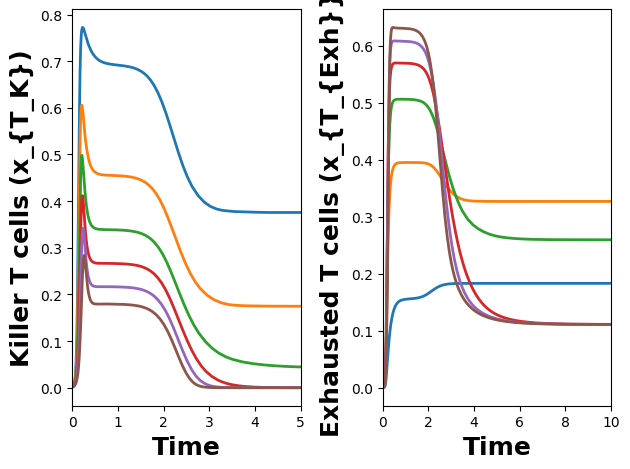

In [50]:
## This code generates the main text plots corresponding to the immune desert TME subtype (Fig. 3 of the manuscript)
### Purpose of the study in Fig. 3(a-b): TO investigate the role of killer T cell exhaustion in driving the TME towards immune desert 
## Initialisation
y_0 = [22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578]
alpha = 0.005  # Immune-accessibility
P = HNSCC_parameters_immune_desert_modelling(alpha)  # Parameters for immune desert TME subtype
Q_ab = P.copy()
Prol_death = np.arange(1, 11, 2)  # Ratio of proliferation to death rate
# Studying the time profiles for Exhausted and killer T cells pre-ICI for different killer to exhaustion rate
Q_ab[29] = P[29] * Prol_death[2] # Adjusting the default proliferation rate for PD1+ defult killer T cells (moderate to high proliferation rate)
Q_ab[30] = 15  # Proliferation rate of PD1- killer T cells
TKPD_TEX = np.arange(1, 31, 5)  # Different conversion rate multiplier from killer to exhausted T cells
for m in range(len(TKPD_TEX)):
    K_TEX=TKPD_TEX[m]*P[35] # Modulating the exhaustion rate
    Q_ab[35]=K_TEX
    def solve_stiff_ode_with_params_im_des():         # Using ivp-solver with BDF method for simulation
    # Initial conditions
        t_span = (0, 70000)
        u = 0                       
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0
                        
    # Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_ab)

    # Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_im_des()
    x_pre[x_pre < 0] = 0
    plt.subplot(1, 2, 1)
    plt.plot(t_pre, x_pre[7,:] / 5000, linewidth=2)  # plotting time profiles PD1+ killer T cells for different exhaustion proliferation balance
    plt.xlabel('Time', fontsize=18, fontweight='bold')
    plt.ylabel('Killer T cells (x_{T_K})', fontsize=18, fontweight='bold')
    plt.xlim([0, 5])
    plt.subplot(1, 2, 2)
    plt.plot(t_pre, x_pre[11,:] / 5000, linewidth=2, linestyle='-') # plotting time profiles Exhausted T cells for different exhaustion proliferation balance
    plt.xlabel('Time', fontsize=18, fontweight='bold')
    plt.ylabel('Exhausted T cells (x_{T_{Exh}})', fontsize=18, fontweight='bold')
    plt.xlim([0, 10])
    plt.tight_layout()

plt.show()


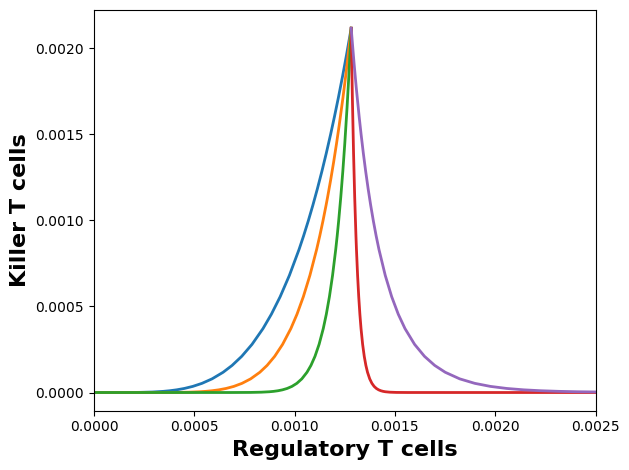

In [51]:
## Purpose of the study in fig 3(c): To demonstrate the possibility of an immune desert (immune cold) phenotype wild abundant regulatory T cells due to CAF-Treg interaction
Q_C=P.copy()                      # Loading the default parameters for immune desert
Prol_death=np.arange(1,11,2)       
Q_C[29]=P[29]*Prol_death[2]      
Q_C[35]=72                       # High exhaustion rate: Ensuring immune desert vis-a-vis killer T cells
CAF_TREG = np.arange(1, 10, 2)   # Modulating CAF-Treg interaction strength
for k in range(len(CAF_TREG)):
    K_CAFTREG=CAF_TREG[k]*P[39]                                       # Modifying the CAF-TREG interaction constant
    Q_C[39]=K_CAFTREG;
    def solve_stiff_ode_with_params_im_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0
                        
    # Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_C)

    # Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_im_des()
    x_pre[x_pre < 0] = 0
    plt.plot(np.log2((1 + x_pre[10,:] / 5000)), np.log2(1 + x_pre[7,:] / 5000), linewidth=2) # Plotting the trajectory in the CAF_TReg plane in log scale.
    plt.xlabel('Regulatory T cells', fontsize=16, fontweight='bold')
    plt.ylabel('Killer T cells', fontsize=16, fontweight='bold')
    plt.xlim([0, 0.0025])
    plt.tight_layout()

plt.show()

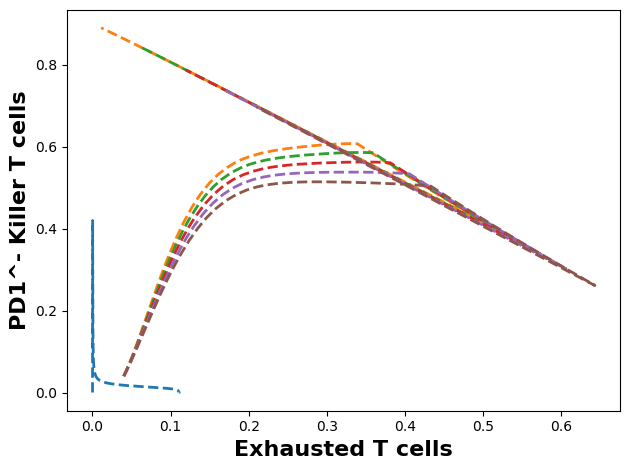

In [52]:
# Purpose of the study in Fig. 3(d): To investigate the effect of ICI on different types of immune desert
Q_D=P.copy()
Prol_death_NPD1=[0.5, 5]                   # Low and moderate proliferation rate
Q_D[10]=5                                  # Constant resource production rate
Q_D[15]=1500                               # killer T cell-driven elimination rate of tumor cells
Q_D[29]=Prol_death_NPD1[0]*Q_D[41]         # Ensuring immune desert for critically low proliferation rate
Q_D[30]=Q_D[29]
anti_PD1=1
def solve_stiff_ode_with_params_im_des():
    # Initial conditions
    t_span = (0, 70000)
    u = 1
    C_IL2 = 0
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_D)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_post_low_prolif, x_post_low_prolif = solve_stiff_ode_with_params_im_des()
plt.plot(x_post_low_prolif[11, :] / 5000, x_post_low_prolif[8, :] / 5000, linewidth=2, linestyle='--') # Killer T cell vs. exhausted T cells in low proliferation immune desert
plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
Q_D[29]=Prol_death_NPD1[1]*Q_D[41]           # Ensuring higher proliferation rate for both PD1- and + killer T cells
Q_D[30]=Q_D[29]                               
Q_D[35]=72                                   # High exhaustion rate. Ensuring exhaustion-driven immune desert
PD1_NPD1=np.arange(0.5,25,5)                 # Modulating the balance between efficiency of anti-PD1 binding with the exhaustion rate
L=len(PD1_NPD1)
for k in range(len(PD1_NPD1)):
    Q_D[34]=PD1_NPD1[L-k-1]
    def solve_stiff_ode_with_params_im_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 1
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0
                        
    # Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_D)

    # Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0+200*np.ones(24), method='BDF')
        return solution.t, solution.y
    t_post_Exh_based, x_post_Exh_based = solve_stiff_ode_with_params_im_des()
    plt.plot(x_post_Exh_based[11, :] / 5000, x_post_Exh_based[8, :] / 5000, linewidth=2, linestyle='--') # Plotting Exhausted vs Killer T cells for different balances between anti-PD1 binding efficacy and exhaustion rate.
    plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
    plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
    plt.tight_layout()
plt.show()

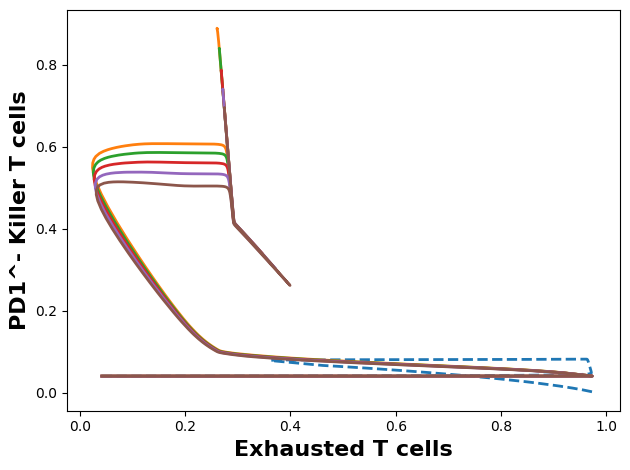

In [53]:
## Purpose of the study in figure 3(e): To examine how the effect of varying anti-PD1 bnding rate reflect on post-ICI tumor cells in immune desert scenario
Prol_death_NPD1=[0.5, 5] # Proliferation to death balance for Killer T cells
Q_E=P.copy()                   # Storing default parameter values
Q_E[10]=5               # Adjusting the constant resource rate
Q_E[15]=1500            # Adjusting the Killer T cell cytotoxicity
Q_E[29]=0.5             # Low proliferation of killer T cell: Immune-desert due to low proliferation
Q_E[30]=Q_E[29]        
anti_PD1=1
def solve_stiff_ode_with_params_im_des():
    # Initial conditions
    t_span = (0, 70000)
    u = 1
    C_IL2 = 0
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_E)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0 + 200*np.ones(24), method='BDF')
    return solution.t, solution.y
t_post_Lac, x_post_Lac = solve_stiff_ode_with_params_im_des()
plt.plot(np.sum(x_post_Lac[:5,:],axis=0) / 30000, x_post_Lac[8, :] / 5000, linewidth=2, linestyle='--')  # For critically low proliferation plottiing the total tumor cells vs PD1- killer T cells 
plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
plt.tight_layout()

Q_E[29]=Prol_death_NPD1[1]*Q_E[41]  # Setting up higher proliferation rate
Q_E[30]=Q_E[29]                      
Q_E[35]=72;                         # Ensuring exhaustion-driven immune-desert
PD1_NPD1=np.arange(0.5,25,5)        # Simulating for different anti-PD1 binding rates
L=len(PD1_NPD1);
for m in range(L):
    Q_E[34]=PD1_NPD1[L-m-1]
    def solve_stiff_ode_with_params_im_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 1
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_E)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0 + 200*np.ones(24), method='BDF')
        return solution.t, solution.y
    t_post_Lac_Exh, x_post_Lac_Exh = solve_stiff_ode_with_params_im_des()
    plt.plot(np.sum(x_post_Lac_Exh[:5,:],axis=0) / 30000, x_post_Lac_Exh[8, :] / 5000, linewidth=2)    # For pre-ICI exhaustion-driven the total tumor cells vs PD1- killer T cells 
    plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
    plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
    plt.tight_layout()
plt.show()

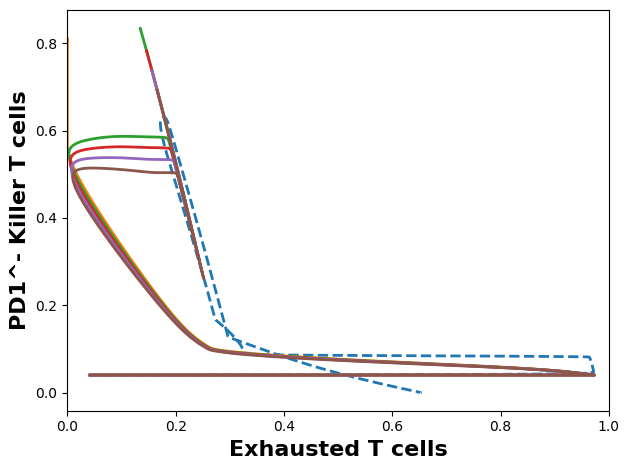

In [55]:
## In presence of Lactate knockout (Figure no. 3(f))
# Purpose of the study: Lactate knockout improves the overall scenario
# Does the same simulation except lactate knockout

C_LAC=10                    # Lactate knockout rate
Prol_death_NPD1=[0.5, 5]
Q_F=P.copy()
Q_F[10]=5
Q_F[15]=1500
Q_F[29]=Prol_death_NPD1[0]*Q_F[41]
Q_F[30]=Q_F[29]
Q_F[35]=72
anti_PD1=1
def solve_stiff_ode_with_params_im_des():   # Simulating the odes with high Lactate inhibition rates ensuring Lactate knock out
    # Initial conditions
    t_span = (0, 70000)
    u = 1
    C_IL2 = 0
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 10
    C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_F)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0 + 200*np.ones(24), method='BDF')
    return solution.t, solution.y
t_post_Lac, x_post_Lac = solve_stiff_ode_with_params_im_des()
plt.plot(np.sum(x_post_Lac[:5,:],axis=0) / 30000, x_post_Lac[8, :] / 5000, linewidth=2, linestyle='--')
plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
plt.xlim([0,1])
plt.tight_layout()
Q_F[29]=Prol_death_NPD1[1]*Q_F[41]
Q_F[30]=Q_F[29];
Q_F[35]=72;
PD1_NPD1=np.arange(0.5,25,5)
L=len(PD1_NPD1);
for m in range(L):
    Q_E[34]=PD1_NPD1[L-m-1]
    def solve_stiff_ode_with_params_im_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 1
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 10 # Ensuring lactate knockout
        C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q_E)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0 + 200*np.ones(24), method='BDF')
        return solution.t, solution.y
    t_post_Lac_KO, x_post_Lac_KO = solve_stiff_ode_with_params_im_des()
    plt.plot(np.sum(x_post_Lac_KO[:5,:],axis=0) / 30000, x_post_Lac_KO[8, :] / 5000, linewidth=2)
    plt.xlabel('Exhausted T cells', fontsize=16, fontweight='bold')
    plt.ylabel('PD1^- Killer T cells', fontsize=16, fontweight='bold')
    plt.tight_layout()
plt.show()

In [56]:
## Default parameters for fibro desert: Low proliferation to death ratio for fibroblasts
import numpy as np
def HNSCC_parameters_fibro_desert_modelling(alpha):
    P=np.zeros(91)
    
    K_RCST=100
    P[0]=K_RCST               #  per unit of resource per unit of time. Resource to T-exposed tumor stem cell 

    K_RCSNT=100
    P[1]=K_RCSNT              #  per unit of resource per unit of time. Resource to Non-T-exposed tumor stem cell

    K_RCNPDL1=120            
    P[2]=K_RCNPDL1            #  per unit of resource per unit of time. Resource to T-exposed PDL1- tumor cell 

    K_RCRNPDL1=120           
    P[3]=K_RCRNPDL1           #  per unit of resource per unit of time. Resource to Non-T-exposed PDL1- tumor cell

    K_RCPDL1=60
    P[4]=K_RCPDL1             #  per unit of resource per unit of time. Resource to T-exposed PDL1+ tumor cell

    K_RCRPDL1=60
    P[5]=K_RCRPDL1            # per unit of resource per unit of time. Resource to Non-T-exposed PDL1+ tumor cell

    K_RIn=0.5
    P[6]=K_RIn                # Resource per unit time. Default resource intake rate

    alpha_Comp=0.0005               # Resource consumption rate
    P[7]=alpha_Comp
    
## Cancer cell proliferation, interactions, and death
    
    Y_CST=10**4
    P[8]=Y_CST               # Carrying capacity for PD1- T cells

    Y_CPDL1M=10**4
    P[9]=Y_CPDL1M           # Carrying capacity for PD1+ T cells

    Y_RM=10
    P[10]=Y_RM                # Resources. Maximum resource withholding capacity.

    K_TXC=50
    P[11]=K_TXC               # Exhausted T cells-driven growth of tumor cells.

    K_FWTC=0.005
    P[12]=K_FWTC              # Fraction of wild type fibroblasts in proximity with the tumor cells.

    K_CAFC=0
    P[13]=K_CAFC              # CAF-driven growth of the tumor cells.

    K_CAFCR=2.5
    P[14]=K_CAFCR             # CAF-driven growth of the tumor non-T exposed cells.
            
    K_TKC=50
    P[15]=K_TKC               # T cells-driven apoptosis of tumor cells.

    K_Lac=0.005
    P[16]=K_Lac               # Inhibition rate of lactate

    K_TKCIFNG=1
    P[17]=K_TKCIFNG           # IFNG induced T cells-driven apoptosis of tumor cells.

    P[18]=alpha               # CAF barrier
    
    K_CAFB=0.001
    P[19]=K_CAFB              # Barrier formation rate

    K_CSTCNPDL1=8
    P[20]=K_CSTCNPDL1         # Stem to PDL1- 

    K_CSTCPDL1=8
    P[21]=K_CSTCPDL1          # Stem to PDL1+ 

    K_CPDNPD=2
    P[22]=K_CPDNPD            # NPDL1 to PDL1 conversion

    K_CSTD=0.0005
    P[23]=K_CSTD              # Death rate of Tumor stem

    K_CNPDL1D=8
    P[24]=K_CNPDL1D           # Death rate of NPDL1

    K_CPDL1D=8
    P[25]=K_CPDL1D            # Death rate of PDL1

    K_ResD=8
    P[26]=K_ResD              # Degradation of Resources

    Delta=10**-3
    P[27]=Delta               # Width of the barrier

## T cell proliferation, interactions, and death

    Y_TKM=5000
    P[28]=Y_TKM               # Carrying capacity for PD1+ T cells

    K_TKPD=45
    P[29]=K_TKPD              # Proliferation rate of PD1+ T cells 

    K_TKNPD=60
    P[30]=K_TKNPD             # Proliferation rate of PD1- T cells

    K_TH=30
    P[31]=K_TH                # Proliferation rate of helper T cells

    K_TREG=15
    P[32]=K_TREG              # Proliferation rate of regulator T cells

    K_TEX=12
    P[33]=K_TEX               # Proliferation rate of Exhausted T cells

    K_TKPDNPD1=150000
    P[34]=K_TKPDNPD1          # Conversion from PD1+ to PD1- T cells

    K_TKPDTEX=8
    P[35]=K_TKPDTEX           # Conversion from PD1+ T cels to exhausted T cells  

    K_THTK=50
    P[36]=K_THTK              # Helper induced proliferation of Killer T cells

    K_IL2TK=10
    P[37]=K_IL2TK             # IL-2 induced proliferation of killer T cells

    K_CNPDT=80
    P[38]=K_CNPDT             # MHC sensing of tumor cells for immune activation

    K_CAFTREG=0
    P[39]=K_CAFTREG           # CAF induced proliferation of regulatory T cells

    K_TREGTH=0.001
    P[40]=K_TREGTH            # TREG induced inhibition of helper T cells  

    K_TKPDD=8
    P[41]=K_TKPDD             # Death rate of killer PD1+ T cells

    K_THD=7
    P[42]=K_THD               # Death rate of helper T cells

    K_TREGD=9
    P[43]=K_TREGD             # Death rate of regulatory T cells

    K_TEXD=10
    P[44]=K_TEXD              # Death rate for exhausted T cells

## CAF proliferation, interactions, and death

    Y_FWTM=5000
    P[45]=Y_FWTM              # maximum carrying capacity of Fibroblasts

    K_FWT=1.2
    P[46]=K_FWT              # Proliferation rate of wild type fibroblasts

    K_CAF=1
    P[47]=K_CAF               # Proliferation rate of CAF cells

    K_OPNCAF=0.5
    P[48]=K_OPNCAF           # OPN-induced Proliferation rate of CAF cells

    K_CTCAF=0.5
    P[49]=K_CTCAF             # Tumor cells-induced growth of CAF

    K_CTCAFR=0.5
    P[50]=K_CTCAFR           # Proximity factor for CAF and resistant tumor cells  

    K_LIF=0.0005
    P[51]=K_LIF               # LIF fraction available for conversion

    K_LIFT=1              
    P[52]=K_LIFT             # Hill like dissociation constant

    K_M2CAF=0.2
    P[53]=K_M2CAF             # M2-driven proliferation rate for CAFs 

    K_FWTCAF=5
    P[54]=K_FWTCAF            # LIF-driven conversion rate from FWT to CAFs

    K_CAFFWT=1
    P[55]=K_CAFFWT            # Conversion from CAF to wild type fibroblasts

    K_FWTD=15
    P[56]=K_FWTD              # Death rate of wild type fibroblasts

    K_CAFD=15
    P[57]=K_CAFD              # Death rate of CAFs

## Macrophage proliferation, interactions, and death

    Y_MM=5000
    P[58]=Y_MM                # Carrying capacity

    K_M1=25
    P[59]=K_M1                # Growth rate of M1 phase macrophage

    K_M2=15
    P[60]=K_M2                # Growth rate of M2 phase macrophage

    K_CANM1=10
    P[61]=K_CANM1             # Tumor cells-driven proliferation of macrophages

    K_M2M1=3
    P[62]=K_M2M1
  
    K_M1M2ICAM1=30
    P[63]=K_M1M2ICAM1         # ICAM1-driven conversion rate

    K_ICAM1=5*10**-4
    P[64]=K_ICAM1             # Fraction of ICAM1 in proximity with M1 macrophage.

    K_CAFM2=0
    P[65]=K_CAFM2             # Tumor cells-driven proliferation of macrophages

    K_M1D=5
    P[66]=K_M1D               # Death rate of M1 phase macrophage 

    K_M2D=5
    P[67]=K_M2D                # Death rate of M2 phase macrophage 

## Cytokines, Chemokines, and Lactate
# IL-2
    K_TIL2=5
    P[68]=K_TIL2               # IL-2 secretion by T cells

    K_IL2D=6
    P[69]=K_IL2D               # IL-2 degradation

# IFNG
    K_TIFNG=20
    P[70]=K_TIFNG              # IFNG secretion by T cells

    K_OPNIFNG=0.01
    P[71]=K_OPNIFNG            # IFNG inhibition by OPN 
    
    K_IFNGD=5
    P[72]=K_IFNGD              # IFNG degradation rate

# ICAM1
    K_TICAM1=5
    P[73]=K_TICAM1             # ICAM1 secretion by T cells

    K_ICAM1D=5
    P[74]=K_ICAM1D             # ICAM1 degradation rate

# OPN
    K_CANOPN=3
    P[75]=K_CANOPN             # OPN secretion by Tumor cells

    K_CAFOPN=5
    P[76]=K_CAFOPN             # OPN Secretion by CAF

    K_IRFOPN=0.05
    P[77]=K_IRFOPN             # IRF-driven inhibition of OPN

    K_OPND=4
    P[78]=K_OPND               # OPN Degradation rate

# LIF
    K_CANLIF=6
    P[79]=K_CANLIF             # LIF secretion by Tumor cells
    
    K_CAFLIF=0.05
    P[80]=K_CAFLIF             # LIF Secretion by CAF

    K_LIFD=8
    P[81]=K_LIFD               # LIF Degradation rate

# IL-8
    K_CANIL8=2
    P[82]=K_CANIL8             # IL8 secretion by Tumor cells

    K_CAFIL8=2
    P[83]=K_CAFIL8             # IL8 Secretion by CAF

    K_M2IL8=15
    P[84]=K_M2IL8              # IL8 secretion by M2

    K_IL8D=5
    P[85]=K_IL8D               # LIF Degradation rate


# IRF8
    K_M1IRF8=2
    P[86]=K_M1IRF8             # IRF8 secretion by M1

    K_IRF8D=2
    P[87]=K_IRF8D              # IRF8 Degradation rate


# Lactate
    K_M2Lac=2
    P[88]=K_M2Lac              # Lac secretion by M2

    K_CANLac=0.2
    P[89]=K_CANLac              # Lac secretion by Tumor cells

    K_LacD=4
    P[90]=K_LacD               # Lac Degradation rate 
    
    return P

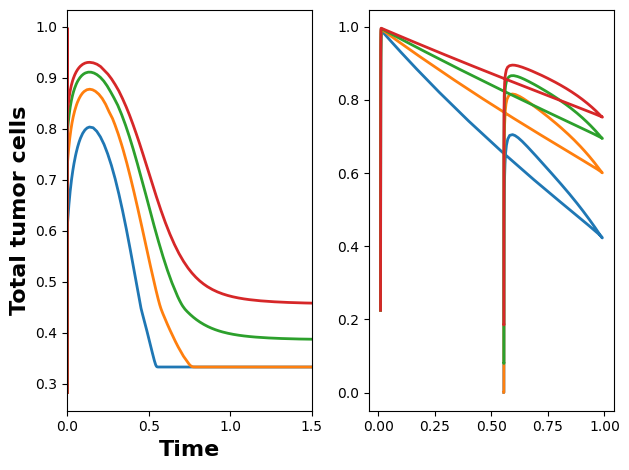

In [60]:
## This code generates the main text plots corresponding to the fibro desert TME subtype (Figure 4)
## Initialisation
import numpy as np
from scipy.integrate import odeint
from scipy.stats import qmc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
y_0 = [2000, 0, 2500, 4000, 0, 0, 59.8564, 50, 0, 40, 20, 30, 150, 150, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 0, 13.7578] # initial state for simulation
alpha = 0.005                                                                                                       # Immune accessibility index (Not a factor here but for computational issues alpha is kept non-zero)
anti_PD1 = 2                                                                                                       # ICI concentration
P = HNSCC_parameters_fibro_desert_modelling(alpha)                                                                 # Parameters for fibro-desert

## Pre-ICI: Total tumor cells and Killer T cells for different killer-exhaustive conversion to cytotoxic activity ratio. (Figures no. 4(a-b))
# Purpose of the study: The exhausted T cells over all increases the total 
# population of pre-ICI T-cells even in hyper-cytotoxic environment mainly 
# for the increase of PDL1- tumor stem cells.  
Q=P.copy()
K_TexC=np.arange(10,31,6) # Multiplier for the conversion from the killer to exhausted T cells
C_total=[] # Total tumor cells
L=len(K_TexC)
for k in range(L):
    K_TXC=P[11]
    Q[11]=K_TXC*K_TexC[k] # Modifying the exhausted-tumor interaction rate  
    def solve_stiff_ode_with_params_fib_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0
                        
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre_fib_des, x_pre_fib_des = solve_stiff_ode_with_params_fib_des()
    plt.subplot(1, 2, 1)
    plt.plot(t_pre_fib_des, np.sum(x_pre_fib_des[:5,:],axis=0) / 30000, linewidth=2)
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Total tumor cells', fontsize=16, fontweight='bold')
    plt.xlim([0,1.5])
    plt.subplot(1, 2, 2)
    plt.plot(x_pre_fib_des[7,:] / 5000, (x_pre_fib_des[0, :]+ x_pre_fib_des[2,:]) / 20000, linewidth=2) 
    plt.tight_layout()
plt.show()

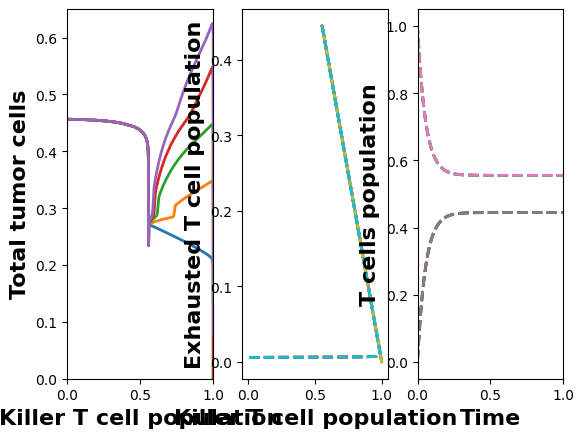

In [62]:
## Post ICI: Study of post ICI tumor cell vs T cell population for different constant resources             (Figures no. 4(c-d))
# Purpose of the study: 1)The constant resource rates can lead to recurrence after a succesfull ICI therapy.
# ICI reduces the total exhausted T cells count drastically.
x_pre_fib_des.shape
nrows, ncols=x_pre_fib_des.shape
y_0=np.array(x_pre_fib_des[:,ncols-1])
Res_Mul=np.arange(1,10,2) # Multiplier for different resource rates
Q[11]=P[11]*K_TexC[1]
LR=len(Res_Mul)
for l1 in range(LR):
    Q[10]=P[10]*Res_Mul[l1]  # Modifying Resource rates
    def solve_stiff_ode_with_params_fib_des():
    # Initial conditions
        t_span = (0, 70000)
        u = 2
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
        
    t_post_fib_des, x_post_fib_des = solve_stiff_ode_with_params_fib_des()
    plt.subplot(1,3,1)
    plt.plot(x_post_fib_des[8,:]/5000,(x_post_fib_des[0,:]+x_post_fib_des[2,:]+x_post_fib_des[3,:])/30000,linewidth=2) # Potting post-ICI tumor cells for different resource rates: Pssibility for recurrence
    plt.xlabel('Killer T cell population', fontsize=16, fontweight='bold')
    plt.ylabel('Total tumor cells', fontsize=16, fontweight='bold')
    plt.ylim([0, 0.65])
    plt.xlim([0, 1])
    plt.subplot(1,3,2)
    plt.plot((x_post_fib_des[8,:]+x_post_fib_des[7,:])/5000, x_post_fib_des[11,:]/5000,linewidth=2)        # Post-ICI T_exhausted-Killer T trajectory. This plot does not figure in the main manuscript
    plt.plot((x_pre_fib_des[8,:]+x_pre_fib_des[7,:])/5000,x_pre_fib_des[11,:]/5000,linewidth=2, linestyle='--')
    plt.xlabel('Killer T cell population', fontsize=16, fontweight='bold')
    plt.ylabel('Exhausted T cell population', fontsize=16, fontweight='bold')
    plt.subplot(1,3,3)                                                                                      # Ploting the time profiles for killer and exhausted T cells pre- and port- ICI (Fig 4(c))
    plt.plot(t_pre_fib_des[0:149],(x_pre_fib_des[8,0:149]+x_pre_fib_des[7,0:149])/5000, linewidth=2, linestyle='--')
    plt.plot(t_pre_fib_des[0:149],x_pre_fib_des[11,0:149]/5000, linewidth=2, linestyle='--')
    t_post1=t_pre_fib_des[149]*np.ones(len(t_post_fib_des))+t_post_fib_des
    plt.plot(t_post1, (x_post_fib_des[8,:]+x_post_fib_des[7,:])/5000, linewidth=2)
    plt.plot(t_post1,x_post_fib_des[11,:]/5000, linewidth=2)
    plt.xlabel('Time', fontsize=16,fontweight='bold')
    plt.ylabel('T cells population', fontsize=16,fontweight='bold')
    plt.xlim([0,1])
plt.show()

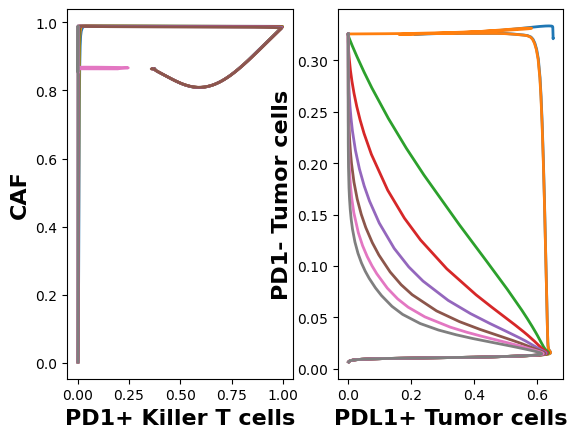

In [63]:
### This code generates the main text plots corresponding to the Immune Rich TME subtype
## Figure 5 of main manuscript, supplementary figures S2 and S4 
## Initialisation
## Purpose of Figures 5(a): Exploring the pre-ICI CAF-T landscape for different killer T cell proliferation rates and the corresponding tumor cell counts 
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578]
alpha=0.005 # Immune rich implies high immune accessibility
P=HNSCC_parameters(alpha)
P[13]=10 # Low CAF-driven growth of the tumor cells
Q=P.copy() 
T_KProl=[0, 0.05, 21, 31, 41, 51, 61, 71] # Deiiferent proliferation rates for killer T cells
L=len(T_KProl)
Tk=[]
CAF=[]
Q2=Q.copy()
for k in range(L):
    Q[29]=T_KProl[k] # Modifying the proliferation rate of T cells
    Q2[29]=T_KProl[L-k-1]
    def solve_stiff_ode_with_params_imm_rich1():
    # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q2)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
        
    t_pre_imm_rich1, x_pre_imm_rich1 = solve_stiff_ode_with_params_imm_rich1()
    plt.subplot(1,2,1)
    plt.plot(x_pre_imm_rich1[7,:]/5000, x_pre_imm_rich1[13,:]/5000, linewidth=2) # Plotting the pre-ICI killer T cells vs CAF for different T cell prolifeation rates 
    plt.xlabel('PD1+ Killer T cells', fontsize=16, fontweight='bold')
    plt.ylabel('CAF', fontsize=16, fontweight='bold')
    def solve_stiff_ode_with_params_imm_rich2():
    # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    
    t_pre_imm_rich2, x_pre_imm_rich2 = solve_stiff_ode_with_params_imm_rich2()
    plt.subplot(1,2,2)
    plt.plot((x_pre_imm_rich2[0,:]+x_pre_imm_rich2[2,:])/30000, x_pre_imm_rich2[3,:]/30000, linewidth=2) # Plotting the post-ICI killer T cells vs total tumor for different T cell prolifeation rates 
    plt.xlabel('PDL1+ Tumor cells', fontsize=16, fontweight='bold')
    plt.ylabel('PD1- Tumor cells', fontsize=16, fontweight='bold')

plt.show()

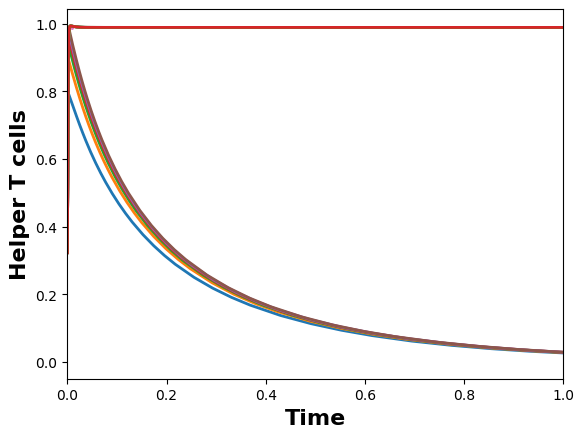

In [16]:
## Simulation of helper T cells for different ration between CAF-Tumor and CAF-Treg (Figure No.-5(b))
# Purpose of the study: CAF plays a dual role in regulating the helper T cell population
T_CAF_REG=15
Q1=P.copy()
Q1[38]=150
CAF_C_MUL=[0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 5.5, 6, 6.5, 7, 9, 11]
Q1[40]=0.001
Y_0=[654.8, 354.5, 1227.8, 1997.2, 860.0, 1789.7, 29.3, 704.7, 0, 1615.7, 1287.4, 1536, 1395.2, 222.9, 314, 925.6, 1869.7, 1109.7, 521.1, 1011.7, 1468.4, 1724.2, 429.1, 117]
for k1 in range(len(CAF_C_MUL)):
    Q1[39]=T_CAF_REG
    Q1[13]=T_CAF_REG*CAF_C_MUL[k1]
    def solve_stiff_ode_with_params_imm_rich2():
    # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q1)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, Y_0, method='BDF')
        return solution.t, solution.y
    
    t_pre_imm_rich3, x_pre_imm_rich3 = solve_stiff_ode_with_params_imm_rich2()
    plt.plot(t_pre_imm_rich3,x_pre_imm_rich3[9,:]/5000,linewidth=2)
    plt.xlim([0, 1])
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Helper T cells', fontsize=16, fontweight='bold')
plt.show()

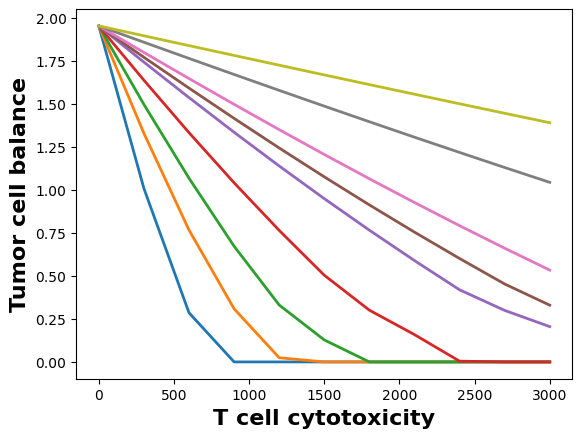

In [17]:
## Proportion of tumor cells wrt different cytotoxic activity for different T cell exhaustion rate (Figure No.-5(c))
# 1)Purpose of the study: The exhausted T cells modifies the balance of the PDL1-ve and +ve tumor cells towards PDL1-ve tumor cells

T_KPDexh=[16, 32, 50, 80, 128, 150,180,300,500]                                        # Multiplier for conversion from killer T cells to exhausted
K_TKC=[0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000]                 # Cytotoxic activity for killer T cells
P=HNSCC_parameters(0.005)
P[13]=10
Q=P.copy()
Tum_cell_balance=[]                                                                 # Ratio from PDL1-ve to +ve tumor cells
for m in range(len(T_KPDexh)):
    Q[35]=T_KPDexh[m]                                                            # Modifying the conversion rate from killer-exhaustion
    y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578]
    Tum_cell_balance=[]  
    for l in range(len(K_TKC)):
        Q[15]=K_TKC[l]                                                           # Modifying the cytotoxic activity of killer T cells
        def solve_stiff_ode_with_params_imm_rich_pre_ICI():
    # Initial conditions
            t_span = (0, 70000)
            u = 0
            C_IL2 = 0
            C_LIF = 0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
    
        t_pre_imm_rich_pre_ICI, x_pre_imm_rich_pre_ICI = solve_stiff_ode_with_params_imm_rich_pre_ICI()
        ncol=len(t_pre_imm_rich_pre_ICI)
        y_0=np.array(x_pre_imm_rich_pre_ICI[:, ncol-1])
        T1=(x_pre_imm_rich_pre_ICI[0,ncol-1]+x_pre_imm_rich_pre_ICI[2,ncol-1])/x_pre_imm_rich_pre_ICI[3,ncol-1]
        Tum_cell_balance.append(T1)
    plt.plot(K_TKC,Tum_cell_balance,linewidth=2)
    plt.xlabel('T cell cytotoxicity', fontsize=16, fontweight='bold')
    plt.ylabel('Tumor cell balance', fontsize=16, fontweight='bold')
plt.show()

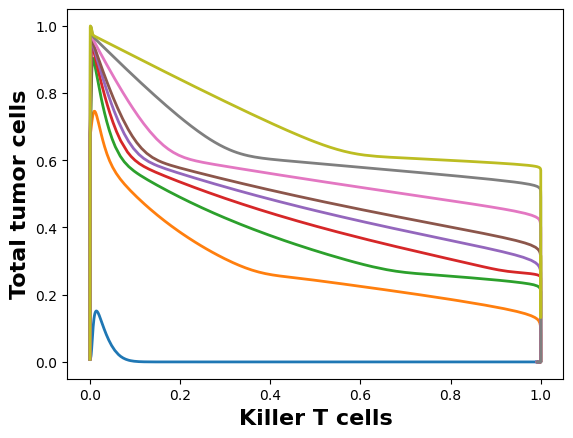

In [18]:
## Post-ICI: Plotting T vs Tumor cells for different CAF-C interaction rate (Figure No.-5(e))
# Purpose of the study: 1) Possibility and elimination of recurrence after successfull ICI
anti_PD1=1;
CAF_C=[0, 60, 120, 180, 240, 300, 500, 1000, 2000]
P=HNSCC_parameters(0.005)
Q=P.copy()
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578]

for n in range(len(CAF_C)):
    Q[13]=CAF_C[n]                # Modifying CAF-C interactions
    def solve_stiff_ode_with_params_imm_rich_post_ICI():
    # Initial conditions
            t_span = (0, 70000)
            u = 1
            C_IL2 = 0
            C_LIF = 0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
    t_post_imm_rich, x_post_imm_rich = solve_stiff_ode_with_params_imm_rich_post_ICI()
    plt.plot(x_post_imm_rich[8,:]/5000,(x_post_imm_rich[0,:]+x_post_imm_rich[2,:]+x_post_imm_rich[3,:])/30000, linewidth=2) # Plotting T vs. total Tumor cells
    plt.xlabel('Killer T cells',fontsize=16, fontweight='bold')
    plt.ylabel('Total tumor cells', fontsize=16, fontweight='bold')

plt.show()

Text(0, 0.5, 'Tumor suppressive fibroblasts')

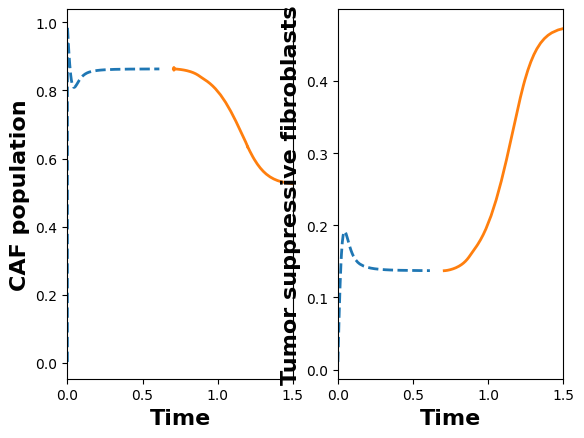

In [19]:
## Plotting CAF-FWT population post ICI (Figure No.-Supplementary figure 4)
# Purpose of study: Immune-Rich TME reverse the pre-ICI CAF-FWT balance: A characteristics of Immune-Rich subtype 
P=HNSCC_parameters(0.005)
P[13]=10
Q=P.copy()
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition for Simulation
def solve_stiff_ode_with_params_imm_rich_pre_ICI():
# Initial conditions
    t_span = (0, 70000)
    u = 0
    C_IL2 = 0
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_pre_imm_rich, x_pre_imm_rich = solve_stiff_ode_with_params_imm_rich_pre_ICI()
ncol=len(t_pre_imm_rich)
y_0=np.array(x_pre_imm_rich[:, ncol-1])
def solve_stiff_ode_with_params_imm_rich_post_ICI():
# Initial conditions
    t_span = (0, 70000)
    u = 1
    C_IL2 = 0
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_post_imm_rich, x_post_imm_rich = solve_stiff_ode_with_params_imm_rich_post_ICI()
indices = np.where(t_pre_imm_rich <= 0.8)[0]
# Get the maximum index
L1 = np.max(indices)
plt.subplot(1,2,1)
t_post_1=t_post_imm_rich+t_pre_imm_rich[L1]*np.ones(len(t_post_imm_rich))
plt.plot(t_pre_imm_rich[0:L1],x_pre_imm_rich[13,0:L1]/5000, linewidth=2,linestyle='--') # Plotting pre-ICI CAF population wrt time
plt.plot(t_post_1,x_post_imm_rich[13,:]/5000, linewidth=2, linestyle='-') # Plotting post-ICI CAF population wrt time
plt.xlim([0, 1.5])
plt.xlabel('Time', fontsize=16,fontweight='bold')
plt.ylabel('CAF population',fontsize=16,fontweight='bold')
plt.subplot(1,2,2)
plt.plot(t_pre_imm_rich[0:L1],x_pre_imm_rich[12,0:L1]/5000, linewidth=2, linestyle='--') # Plotting pre-ICI Wild type fibroblasts population wrt time
plt.plot(t_post_1,x_post_imm_rich[12,:]/5000, linewidth=2, linestyle='-') # Plotting post-ICI Wild type fibroblasts population wrt time
plt.xlim([0, 1.5])
plt.xlabel('Time', fontsize=16,fontweight='bold')
plt.ylabel('Tumor suppressive fibroblasts',fontsize=16,fontweight='bold')

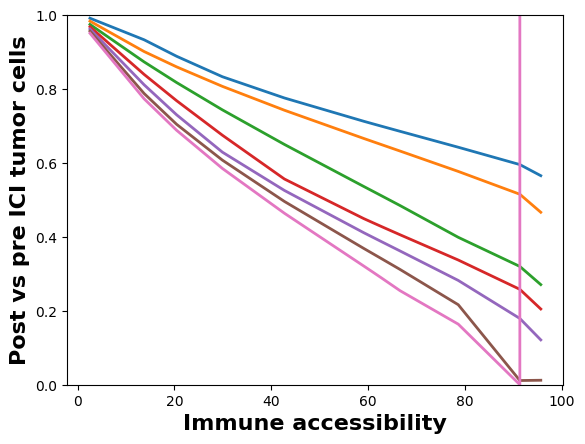

In [20]:
## This code generates the main text figures corresponding to the Fibro-Rich TME subtype (Figure 6)
## Initialisation
y_0=[1089.2, 4820.3, 3302.5, 4106.2, 2576.4, 0990.7, 1340.2, 4718.3, 0, 4673.2, 2045.2, 684.8, 502.5, 797.0, 2504.0, 4912.0, 2114.7, 1753.9, 1601.0, 4659.6, 4097.4, 663.8, 3277.8, 732.9] #Initial condition
tspan=[0, 70000]
alpha=[0.01, 0.02, 0.05, 0.08, 0.09, 0.095, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]
T_KC=[50, 100, 300, 600, 900, 1200, 1500]
FC_TUM=[]
I=[]
Lac=[]
Q=[]
y_01=y_0
P=HNSCC_parameters(0.05)
rho_Cyto_Tex=T_KC/P[11]
for k in range(len(T_KC)):
    FC_TUM=[]
    I=[]
    for j1 in range(len(alpha)):
        P=HNSCC_parameters(alpha[j1])
        Q=P.copy()
        Q[15]=T_KC[k]
        def solve_stiff_ode_with_params_pre_ICI():
# Initial conditions
            t_span = (0, 70000)
            u = 0
            C_IL2 = 0
            C_LIF = 0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI()
        nrow,ncol=x_pre.shape
        Total_Tum_pre=np.sum(x_pre[:5,ncol-1])
        def solve_stiff_ode_with_params_post_ICI():
# Initial conditions
            t_span = (0, 70000)
            u = 1
            y_0=x_pre[:,ncol-1]
            C_IL2 = 0
            C_LIF = 0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, Q)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_post, x_post = solve_stiff_ode_with_params_post_ICI()
        nrow_P,ncol_P=x_post.shape
        Total_Tum_post=np.sum(x_post[:5,ncol_P-1])
        I1=(1-np.tanh(alpha[j1]*Q[19]*x_pre[13,ncol-1]))*100
        I.append(I1)
        FC_TUM_p=Total_Tum_post/Total_Tum_pre
        FC_TUM.append(FC_TUM_p)
        
    plt.plot(I,FC_TUM,linewidth=2) 
    plt.ylim([0,1])
    plt.ylabel('Post vs pre ICI tumor cells',fontsize=16, fontweight='bold')
    plt.xlabel('Immune accessibility',fontsize=16, fontweight='bold')
plt.show()

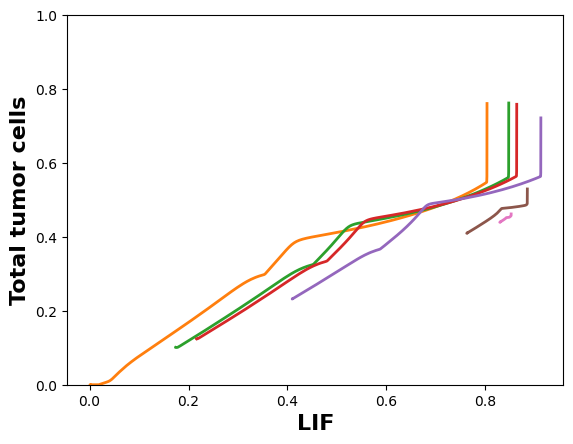

In [21]:
## LIF vs tumor cells for different accessibility (Figure No. 6(c))   
#Purpose of the study: To demonstrate the reduction/stagnation of LIF plays the governing role in the post-ICI CAF population
y_0=[1089.2, 4820.3, 3302.5, 4106.2, 2576.4, 0990.7, 1340.2, 4718.3, 0, 4673.2, 2045.2, 684.8, 502.5, 797.0, 2504.0, 4912.0, 2114.7, 1753.9, 1601.0, 4659.6, 4097.4, 663.8, 3277.8, 732.9] # Initial condition
alpha1=[0.01, 0.02, 0.04, 0.05, 0.1, 0.3, 0.5] # Fraction of CAFs engadged in building the barrier
Y_LIF=22531 # Maximum LIF Carrying capacity. Can be calculated from the equation describing LIF dynamics
for l in range(len(alpha1)):
    P=HNSCC_parameters(alpha1[l])
    def solve_stiff_ode_with_params_pre_ICI():
# Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI()
    nrow, ncol=x_pre.shape
    Total_Tum_pre=np.sum(x_pre[:5,ncol-1])
    def solve_stiff_ode_with_params_post_ICI():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        y_0=x_pre[:,ncol-1]
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI()
    Tum_tot=np.sum(x_post[:5,:],axis=0)     
    plt.plot(x_post[17,:]/Y_LIF,Tum_tot/30000, linewidth=2)                                                     # Plotting Total tumor cells vs LIF
    plt.xlabel('LIF', fontsize=16, fontweight='bold')
    plt.ylabel('Total tumor cells',fontsize=16,fontweight='bold')
    plt.ylim([0,1])
plt.show()

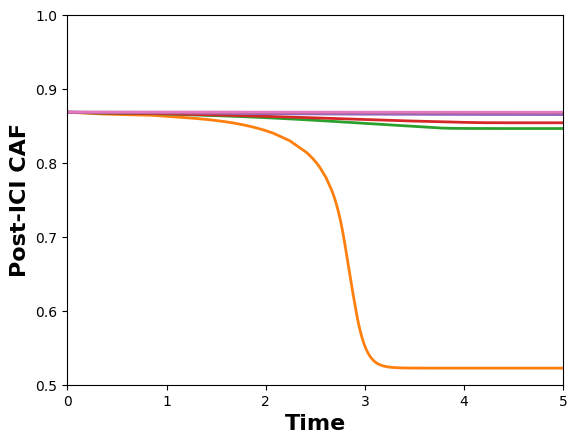

In [29]:
y_0=[1089.2, 4820.3, 3302.5, 4106.2, 2576.4, 0990.7, 1340.2, 4718.3, 0, 4673.2, 2045.2, 684.8, 502.5, 797.0, 2504.0, 4912.0, 2114.7, 1753.9, 1601.0, 4659.6, 4097.4, 663.8, 3277.8, 732.9] # Initial condition
alpha1=[0.01, 0.02, 0.04, 0.05, 0.1, 0.3, 0.5]
for l in range(len(alpha1)):
    P=HNSCC_parameters(alpha1[l])
    def solve_stiff_ode_with_params_pre_ICI():
# Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI()
    nrow,ncol=x_pre.shape
    Total_Tum_pre=np.sum(x_pre[:5,ncol-1])
    def solve_stiff_ode_with_params_post_ICI():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        y_0=x_pre[:,ncol-1]
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI()
    nrow_P,ncol_P=x_post.shape
    plt.plot(t_post,x_post[13,:]/5000,linewidth=2) 
    plt.xlim([0,5])
    plt.ylabel('Post-ICI CAF',fontsize=16, fontweight='bold')
    plt.xlabel('Time',fontsize=16, fontweight='bold')
    plt.ylim([0.5,1])
plt.show()

In [30]:
import numpy as np
def HNSCC_parameters_IL2(alpha):
    P=np.zeros(91)
    
    K_RCST=100
    P[0]=K_RCST               #  per unit of resource per unit of time. Resource to T-exposed tumor stem cell 

    K_RCSNT=100
    P[1]=K_RCSNT              #  per unit of resource per unit of time. Resource to Non-T-exposed tumor stem cell

    K_RCNPDL1=120            
    P[2]=K_RCNPDL1            #  per unit of resource per unit of time. Resource to T-exposed PDL1- tumor cell 

    K_RCRNPDL1=120           
    P[3]=K_RCRNPDL1           #  per unit of resource per unit of time. Resource to Non-T-exposed PDL1- tumor cell

    K_RCPDL1=60
    P[4]=K_RCPDL1             #  per unit of resource per unit of time. Resource to T-exposed PDL1+ tumor cell

    K_RCRPDL1=60
    P[5]=K_RCRPDL1            # per unit of resource per unit of time. Resource to Non-T-exposed PDL1+ tumor cell

    K_RIn=1500
    P[6]=K_RIn                # Resource per unit time. Default resource intake rate

    alpha_Comp=0.0005               # Resource consumption rate
    P[7]=alpha_Comp
    
## Cancer cell proliferation, interactions, and death
    
    Y_CST=10**4
    P[8]=Y_CST               # Carrying capacity for PD1- T cells

    Y_CPDL1M=10**4
    P[9]=Y_CPDL1M           # Carrying capacity for PD1+ T cells

    Y_RM=1
    P[10]=Y_RM                # Resources. Maximum resource withholding capacity.

    K_TXC=50
    P[11]=K_TXC               # Exhausted T cells-driven growth of tumor cells.

    K_FWTC=0.005
    P[12]=K_FWTC              # Fraction of wild type fibroblasts in proximity with the tumor cells.

    K_CAFC=80
    P[13]=K_CAFC              # CAF-driven growth of the tumor cells.

    K_CAFCR=2.5
    P[14]=K_CAFCR             # CAF-driven growth of the tumor non-T exposed cells.
            
    K_TKC=1500
    P[15]=K_TKC               # T cells-driven apoptosis of tumor cells.

    K_Lac=0.005
    P[16]=K_Lac               # Inhibition rate of lactate

    K_TKCIFNG=0
    P[17]=K_TKCIFNG           # IFNG induced T cells-driven apoptosis of tumor cells.

    P[18]=alpha               # CAF barrier
    
    K_CAFB=0.001
    P[19]=K_CAFB              # Barrier formation rate

    K_CSTCNPDL1=8
    P[20]=K_CSTCNPDL1         # Stem to PDL1- 

    K_CSTCPDL1=0
    P[21]=K_CSTCPDL1          # Stem to PDL1+ 

    K_CPDNPD=8
    P[22]=K_CPDNPD            # NPDL1 to PDL1 conversion

    K_CSTD=0.0005
    P[23]=K_CSTD              # Death rate of Tumor stem

    K_CNPDL1D=8
    P[24]=K_CNPDL1D           # Death rate of NPDL1

    K_CPDL1D=8
    P[25]=K_CPDL1D            # Death rate of PDL1

    K_ResD=8
    P[26]=K_ResD              # Degradation of Resources

    Delta=10**-3
    P[27]=Delta               # Width of the barrier

## T cell proliferation, interactions, and death

    Y_TKM=5000
    P[28]=Y_TKM               # Carrying capacity for PD1+ T cells

    K_TKPD=1.5
    P[29]=K_TKPD              # Proliferation rate of PD1+ T cells 

    K_TKNPD=1.5
    P[30]=K_TKNPD             # Proliferation rate of PD1- T cells

    K_TH=1
    P[31]=K_TH                # Proliferation rate of helper T cells

    K_TREG=1.2
    P[32]=K_TREG              # Proliferation rate of regulator T cells

    K_TEX=9
    P[33]=K_TEX               # Proliferation rate of Exhausted T cells

    K_TKPDNPD1=150000
    P[34]=K_TKPDNPD1          # Conversion from PD1+ to PD1- T cells

    K_TKPDTEX=1
    P[35]=K_TKPDTEX           # Conversion from PD1+ T cels to exhausted T cells  

    K_THTK=1
    P[36]=K_THTK              # Helper induced proliferation of Killer T cells

    K_IL2TK=4
    P[37]=K_IL2TK             # IL-2 induced proliferation of killer T cells

    K_CNPDT=1.5
    P[38]=K_CNPDT             # MHC sensing of tumor cells for immune activation

    K_CAFTREG=1
    P[39]=K_CAFTREG           # CAF induced proliferation of regulatory T cells

    K_TREGTH=0.001
    P[40]=K_TREGTH            # TREG induced inhibition of helper T cells  

    K_TKPDD=6
    P[41]=K_TKPDD             # Death rate of killer PD1+ T cells

    K_THD=7
    P[42]=K_THD               # Death rate of helper T cells

    K_TREGD=9
    P[43]=K_TREGD             # Death rate of regulatory T cells

    K_TEXD=10
    P[44]=K_TEXD              # Death rate for exhausted T cells

## CAF proliferation, interactions, and death

    Y_FWTM=5000
    P[45]=Y_FWTM              # maximum carrying capacity of Fibroblasts

    K_FWT=50
    P[46]=K_FWT              # Proliferation rate of wild type fibroblasts

    K_CAF=1
    P[47]=K_CAF               # Proliferation rate of CAF cells

    K_OPNCAF=50
    P[48]=K_OPNCAF           # OPN-induced Proliferation rate of CAF cells

    K_CTCAF=0.5
    P[49]=K_CTCAF             # Tumor cells-induced growth of CAF

    K_CTCAFR=2
    P[50]=K_CTCAFR           # Proximity factor for CAF and resistant tumor cells  

    K_LIF=0.0005
    P[51]=K_LIF               # LIF fraction available for conversion

    K_LIFT=1              
    P[52]=K_LIFT             # Hill like dissociation constant

    K_M2CAF=2
    P[53]=K_M2CAF             # M2-driven proliferation rate for CAFs 

    K_FWTCAF=50
    P[54]=K_FWTCAF            # LIF-driven conversion rate from FWT to CAFs

    K_CAFFWT=9
    P[55]=K_CAFFWT            # Conversion from CAF to wild type fibroblasts

    K_FWTD=10
    P[56]=K_FWTD              # Death rate of wild type fibroblasts

    K_CAFD=10
    P[57]=K_CAFD              # Death rate of CAFs

## Macrophage proliferation, interactions, and death

    Y_MM=5000
    P[58]=Y_MM                # Carrying capacity

    K_M1=15
    P[59]=K_M1                # Growth rate of M1 phase macrophage

    K_M2=5
    P[60]=K_M2                # Growth rate of M2 phase macrophage

    K_CANM1=10
    P[61]=K_CANM1             # Tumor cells-driven proliferation of macrophages

    K_M2M1=3                  # Default conversion rate
    P[62]=K_M2M1
  
    K_M1M2ICAM1=30
    P[63]=K_M1M2ICAM1         # ICAM1-driven conversion rate

    K_ICAM1=5*10**-4
    P[64]=K_ICAM1             # Fraction of ICAM1 in proximity with M1 macrophage.

    K_CAFM2=120
    P[65]=K_CAFM2             # Tumor cells-driven proliferation of macrophages

    K_M1D=10
    P[66]=K_M1D               # Death rate of M1 phase macrophage 

    K_M2D=10
    P[67]=K_M2D                # Death rate of M2 phase macrophage 

## Cytokines, Chemokines, and Lactate
# IL-2
    K_TIL2=5
    P[68]=K_TIL2               # IL-2 secretion by T cells

    K_IL2D=6;
    P[69]=K_IL2D               # IL-2 degradation

# IFNG
    K_TIFNG=20
    P[70]=K_TIFNG              # IFNG secretion by T cells

    K_OPNIFNG=0.01
    P[71]=K_OPNIFNG            # IFNG inhibition by OPN 
    
    K_IFNGD=5;
    P[72]=K_IFNGD              # IFNG degradation rate

# ICAM1
    K_TICAM1=5
    P[73]=K_TICAM1             # ICAM1 secretion by T cells

    K_ICAM1D=5
    P[74]=K_ICAM1D             # ICAM1 degradation rate

# OPN
    K_CANOPN=3
    P[75]=K_CANOPN             # OPN secretion by Tumor cells

    K_CAFOPN=5
    P[76]=K_CAFOPN             # OPN Secretion by CAF

    K_IRFOPN=0.05
    P[77]=K_IRFOPN             # IRF-driven inhibition of OPN

    K_OPND=4
    P[78]=K_OPND               # OPN Degradation rate

# LIF
    K_CANLIF=6
    P[79]=K_CANLIF             # LIF secretion by Tumor cells
    
    K_CAFLIF=0.05
    P[80]=K_CAFLIF             # LIF Secretion by CAF

    K_LIFD=8
    P[81]=K_LIFD               # LIF Degradation rate

# IL-8
    K_CANIL8=2
    P[82]=K_CANIL8             # IL8 secretion by Tumor cells

    K_CAFIL8=2
    P[83]=K_CAFIL8             # IL8 Secretion by CAF

    K_M2IL8=15
    P[84]=K_M2IL8              # IL8 secretion by M2

    K_IL8D=5
    P[85]=K_IL8D               # LIF Degradation rate


# IRF8
    K_M1IRF8=2
    P[86]=K_M1IRF8             # IRF8 secretion by M1

    K_IRF8D=2
    P[87]=K_IRF8D              # IRF8 Degradation rate


# Lactate
    K_M2Lac=2
    P[88]=K_M2Lac              # Lac secretion by M2

    K_CANLac=0.2
    P[89]=K_CANLac              # Lac secretion by Tumor cells

    K_LacD=4
    P[90]=K_LacD               # Lac Degradation rate 
    
    return P

(-12.0, 13.0)

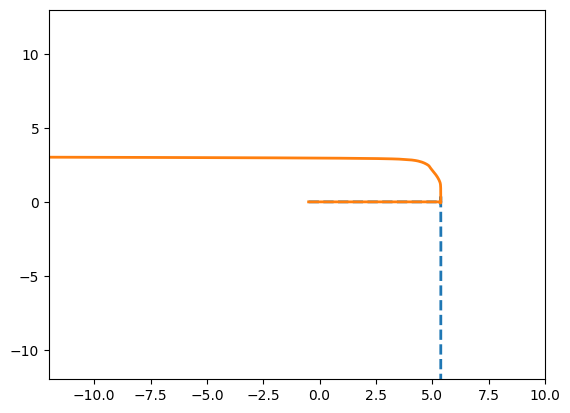

In [31]:
## This code generates the main text figures depicting the effects of IL-2 (Figure 7)
## Initialisation
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 1, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 0, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition
y_1=y_0
C_IL2=np.arange(0,2,0.5)            
C_IL21=np.arange(2.05,3,0.02)       # IL-2 levels
C_IL2_A=np.concatenate((C_IL2,C_IL21))
alpha=0.005                               # Fixing the immune accessibility
P=HNSCC_parameters_IL2(alpha)            # Loading the parameters
tspan=[0, 70000]
anti_PD1=1
## Killer T cells vs tumor cells for IL-2 intake (Figure No. 7(a))
# Purpose of the study: IL-2 based treatment works in an immune accessible environment

def solve_stiff_ode_with_params_post_ICI1():
# Initial conditions
    t_span = (0, 70000)
    u = 1
    c_il2 = C_IL2[len(C_IL2)-1]
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, c_il2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_post, x_post = solve_stiff_ode_with_params_post_ICI1()

def solve_stiff_ode_with_params_post_ICI2():
# Initial conditions
    t_span = (0, 70000)
    u = 1
    c_il21 = C_IL21[len(C_IL21)-1]
    C_LIF = 0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, c_il21, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_post1, x_post1 = solve_stiff_ode_with_params_post_ICI2()

x_post[x_post<0]=0
x_post1[x_post1<0]=0
plt.plot(np.log(np.sum(x_post[:2,:],axis=0)/(y_0[0]+y_0[1]+y_0[2])),np.log(np.add(x_post[7,:],x_post[8,:])),linewidth=2,linestyle='--')
plt.plot(np.log(np.sum(x_post1[:2,:],axis=0)/(y_0[0]+y_0[1]+y_0[2])),np.log(np.add(x_post1[7,:],x_post1[8,:])),linewidth=2)
plt.xlim([-12, 10])
plt.ylim([-12, 13])

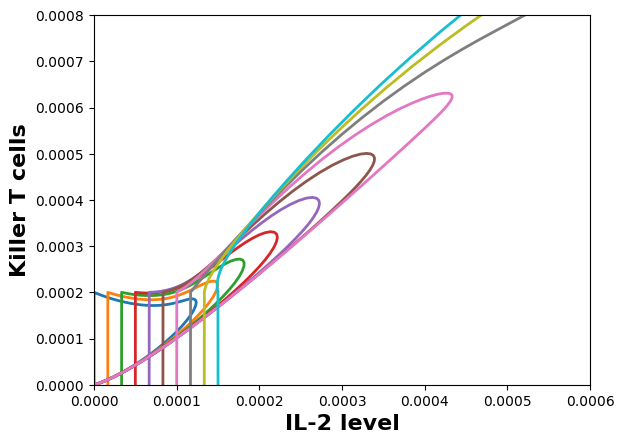

In [32]:
## IL-2 vs Killer T for different initial IL-2 values  (Figure No. 7(b))
# Purpose of the study: A small amount of IL-2 impulse is adequate to displace the TME from an immune deseert to immune hot subtype 
IL_2U=np.arange(0,1,0.1) # Initial IL-2

for L in range(len(IL_2U)):
    y_0[16]=IL_2U[L]
    def solve_stiff_ode_with_params_post_ICI():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        c_il21 =0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, c_il21, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI()
    plt.plot(x_post[16,:]/6000, x_post[8,:]/5000, linewidth=2)        # Plotting IL-2 vs. Killer T cells
    plt.xlabel('IL-2 level',fontsize=16, fontweight='bold')
    plt.ylabel('Killer T cells',fontsize=16, fontweight='bold')
    plt.ylim([0, 0.0008]) # For the inset
    plt.xlim([0,0.0006])
plt.show()

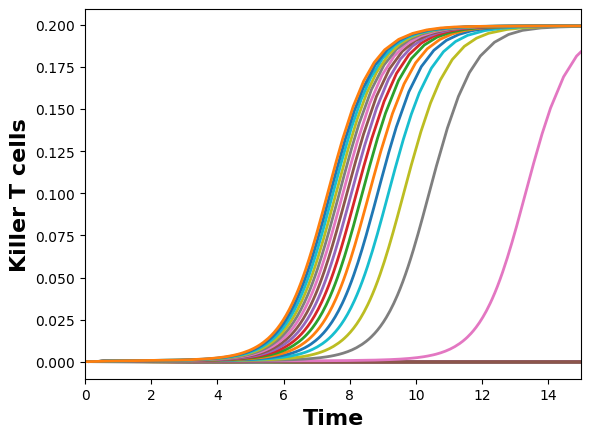

In [33]:
## Killer T cells profiles for different IL-2 intake (Figure No. 7(c))
# Purpose of the study: IL-2-based treatment tap into the positive feedback between IL-2 and Killer T cells
C_IL2=np.arange(0,2,0.5)            
C_IL21=np.arange(2.05,3,0.02)      #IL-2 levels
C_IL2_A=np.concatenate((C_IL2,C_IL21))
P=HNSCC_parameters_IL2(alpha); # Loading the parameters
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 1, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 0, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition

for k in range(len(C_IL2_A)):
    def solve_stiff_ode_with_params_post_ICI4():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        c_il2_A =C_IL2_A[k]
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, c_il2_A, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI4()
    x_post[x_post<0]=0;
    plt.plot(t_post,np.add(x_post[7,:],x_post[8,:])/5000, linewidth = 2)           # Plotting killer T cell profiles
    plt.xlim([0, 15])
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Killer T cells',fontsize=16, fontweight='bold')
plt.show()

In [34]:
import numpy as np
def HNSCC_parameters_OPN(alpha):
    P=np.zeros(91)
    
    K_RCST=100
    P[0]=K_RCST               #  per unit of resource per unit of time. Resource to T-exposed tumor stem cell 

    K_RCSNT=100
    P[1]=K_RCSNT              #  per unit of resource per unit of time. Resource to Non-T-exposed tumor stem cell

    K_RCNPDL1=120            
    P[2]=K_RCNPDL1            #  per unit of resource per unit of time. Resource to T-exposed PDL1- tumor cell 

    K_RCRNPDL1=120           
    P[3]=K_RCRNPDL1           #  per unit of resource per unit of time. Resource to Non-T-exposed PDL1- tumor cell

    K_RCPDL1=10
    P[4]=K_RCPDL1             #  per unit of resource per unit of time. Resource to T-exposed PDL1+ tumor cell

    K_RCRPDL1=10
    P[5]=K_RCRPDL1            # per unit of resource per unit of time. Resource to Non-T-exposed PDL1+ tumor cell

    K_RIn=1500
    P[6]=K_RIn                # Resource per unit time. Default resource intake rate

    alpha_Comp=0.0005               # Resource consumption rate
    P[7]=alpha_Comp
    
## Cancer cell proliferation, interactions, and death
    
    Y_CST=10**4
    P[8]=Y_CST               # Carrying capacity for PD1- T cells

    Y_CPDL1M=10**4
    P[9]=Y_CPDL1M           # Carrying capacity for PD1+ T cells

    Y_RM=2
    P[10]=Y_RM                # Resources. Maximum resource withholding capacity.

    K_TXC=50
    P[11]=K_TXC               # Exhausted T cells-driven growth of tumor cells.

    K_FWTC=0.005
    P[12]=K_FWTC              # Fraction of wild type fibroblasts in proximity with the tumor cells.

    K_CAFC=80
    P[13]=K_CAFC              # CAF-driven growth of the tumor cells.

    K_CAFCR=2.5
    P[14]=K_CAFCR             # CAF-driven growth of the tumor non-T exposed cells.
            
    K_TKC=1500
    P[15]=K_TKC               # T cells-driven apoptosis of tumor cells.

    K_Lac=0.05
    P[16]=K_Lac               # Inhibition rate of lactate

    K_TKCIFNG=1
    P[17]=K_TKCIFNG           # IFNG induced T cells-driven apoptosis of tumor cells.

    P[18]=alpha               # CAF barrier
    
    K_CAFB=0.001
    P[19]=K_CAFB              # Barrier formation rate

    K_CSTCNPDL1=8
    P[20]=K_CSTCNPDL1         # Stem to PDL1- 

    K_CSTCPDL1=8
    P[21]=K_CSTCPDL1          # Stem to PDL1+ 

    K_CPDNPD=8
    P[22]=K_CPDNPD            # NPDL1 to PDL1 conversion

    K_CSTD=0.0005
    P[23]=K_CSTD              # Death rate of Tumor stem

    K_CNPDL1D=8
    P[24]=K_CNPDL1D           # Death rate of NPDL1

    K_CPDL1D=8
    P[25]=K_CPDL1D            # Death rate of PDL1

    K_ResD=8
    P[26]=K_ResD              # Degradation of Resources

    Delta=10**-3
    P[27]=Delta               # Width of the barrier

## T cell proliferation, interactions, and death

    Y_TKM=5000
    P[28]=Y_TKM               # Carrying capacity for PD1+ T cells

    K_TKPD=45
    P[29]=K_TKPD              # Proliferation rate of PD1+ T cells 

    K_TKNPD=60
    P[30]=K_TKNPD             # Proliferation rate of PD1- T cells

    K_TH=25
    P[31]=K_TH                # Proliferation rate of helper T cells

    K_TREG=10
    P[32]=K_TREG              # Proliferation rate of regulator T cells

    K_TEX=15
    P[33]=K_TEX               # Proliferation rate of Exhausted T cells

    K_TKPDNPD1=150000
    P[34]=K_TKPDNPD1          # Conversion from PD1+ to PD1- T cells

    K_TKPDTEX=15
    P[35]=K_TKPDTEX           # Conversion from PD1+ T cels to exhausted T cells  

    K_THTK=40
    P[36]=K_THTK              # Helper induced proliferation of Killer T cells

    K_IL2TK=20
    P[37]=K_IL2TK             # IL-2 induced proliferation of killer T cells

    K_CNPDT=90
    P[38]=K_CNPDT             # MHC sensing of tumor cells for immune activation

    K_CAFTREG=15
    P[39]=K_CAFTREG           # CAF induced proliferation of regulatory T cells

    K_TREGTH=0.001
    P[40]=K_TREGTH            # TREG induced inhibition of helper T cells  

    K_TKPDD=10
    P[41]=K_TKPDD             # Death rate of killer PD1+ T cells

    K_THD=7
    P[42]=K_THD               # Death rate of helper T cells

    K_TREGD=9
    P[43]=K_TREGD             # Death rate of regulatory T cells

    K_TEXD=9
    P[44]=K_TEXD              # Death rate for exhausted T cells

## CAF proliferation, interactions, and death

    Y_FWTM=5000
    P[45]=Y_FWTM              # maximum carrying capacity of Fibroblasts

    K_FWT=50
    P[46]=K_FWT              # Proliferation rate of wild type fibroblasts

    K_CAF=1
    P[47]=K_CAF               # Proliferation rate of CAF cells

    K_OPNCAF=50
    P[48]=K_OPNCAF           # OPN-induced Proliferation rate of CAF cells

    K_CTCAF=0.05
    P[49]=K_CTCAF             # Tumor cells-induced growth of CAF

    K_CTCAFR=1
    P[50]=K_CTCAFR           # Proximity factor for CAF and resistant tumor cells  

    K_LIF=0.0005
    P[51]=K_LIF               # LIF fraction available for conversion

    K_LIFT=1              
    P[52]=K_LIFT             # Hill like dissociation constant

    K_M2CAF=0.05
    P[53]=K_M2CAF             # M2-driven proliferation rate for CAFs 

    K_FWTCAF=50
    P[54]=K_FWTCAF            # LIF-driven conversion rate from FWT to CAFs

    K_CAFFWT=9
    P[55]=K_CAFFWT            # Conversion from CAF to wild type fibroblasts

    K_FWTD=10
    P[56]=K_FWTD              # Death rate of wild type fibroblasts

    K_CAFD=15
    P[57]=K_CAFD              # Death rate of CAFs

## Macrophage proliferation, interactions, and death

    Y_MM=5000
    P[58]=Y_MM                # Carrying capacity

    K_M1=15
    P[59]=K_M1                # Growth rate of M1 phase macrophage

    K_M2=5
    P[60]=K_M2                # Growth rate of M2 phase macrophage

    K_CANM1=10
    P[61]=K_CANM1             # Tumor cells-driven proliferation of macrophages

    K_M2M1=3                  # Default conversion rate
    P[62]=K_M2M1
  
    K_M1M2ICAM1=30
    P[63]=K_M1M2ICAM1         # ICAM1-driven conversion rate

    K_ICAM1=5*10**-4
    P[64]=K_ICAM1             # Fraction of ICAM1 in proximity with M1 macrophage.

    K_CAFM2=120
    P[65]=K_CAFM2             # Tumor cells-driven proliferation of macrophages

    K_M1D=10
    P[66]=K_M1D               # Death rate of M1 phase macrophage 

    K_M2D=10
    P[67]=K_M2D                # Death rate of M2 phase macrophage 

## Cytokines, Chemokines, and Lactate
# IL-2
    K_TIL2=5
    P[68]=K_TIL2               # IL-2 secretion by T cells

    K_IL2D=6;
    P[69]=K_IL2D               # IL-2 degradation

# IFNG
    K_TIFNG=20
    P[70]=K_TIFNG              # IFNG secretion by T cells

    K_OPNIFNG=0.01
    P[71]=K_OPNIFNG            # IFNG inhibition by OPN 
    
    K_IFNGD=5;
    P[72]=K_IFNGD              # IFNG degradation rate

# ICAM1
    K_TICAM1=5
    P[73]=K_TICAM1             # ICAM1 secretion by T cells

    K_ICAM1D=5
    P[74]=K_ICAM1D             # ICAM1 degradation rate

# OPN
    K_CANOPN=3
    P[75]=K_CANOPN             # OPN secretion by Tumor cells

    K_CAFOPN=5
    P[76]=K_CAFOPN             # OPN Secretion by CAF

    K_IRFOPN=0.05
    P[77]=K_IRFOPN             # IRF-driven inhibition of OPN

    K_OPND=4
    P[78]=K_OPND               # OPN Degradation rate

# LIF
    K_CANLIF=6
    P[79]=K_CANLIF             # LIF secretion by Tumor cells
    
    K_CAFLIF=0.05
    P[80]=K_CAFLIF             # LIF Secretion by CAF

    K_LIFD=8
    P[81]=K_LIFD               # LIF Degradation rate

# IL-8
    K_CANIL8=2
    P[82]=K_CANIL8             # IL8 secretion by Tumor cells

    K_CAFIL8=2
    P[83]=K_CAFIL8             # IL8 Secretion by CAF

    K_M2IL8=15
    P[84]=K_M2IL8              # IL8 secretion by M2

    K_IL8D=5
    P[85]=K_IL8D               # LIF Degradation rate


# IRF8
    K_M1IRF8=2
    P[86]=K_M1IRF8             # IRF8 secretion by M1

    K_IRF8D=2
    P[87]=K_IRF8D              # IRF8 Degradation rate


# Lactate
    K_M2Lac=2
    P[88]=K_M2Lac              # Lac secretion by M2

    K_CANLac=0.2
    P[89]=K_CANLac              # Lac secretion by Tumor cells

    K_LacD=4
    P[90]=K_LacD               # Lac Degradation rate 
    
    return P

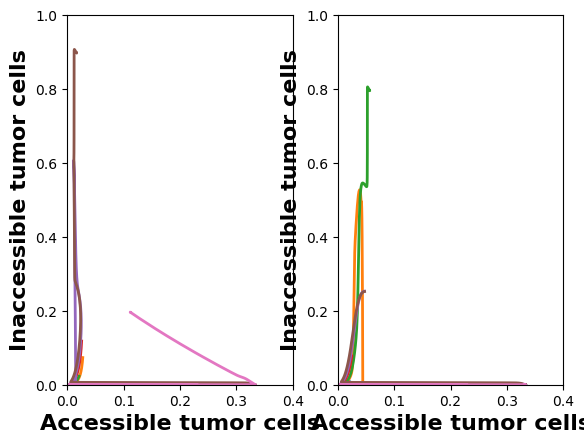

In [35]:
## This code generates the main text figures concerning the OPN and LIF (Figure 8)

## Initialisation
y_0=[5.6304, 7.6874, 8.0805, 3.9277, 7.5001, 0.1805, 0.8207, 2.5095, 0, 7.9163, 7.5867, 8.0238, 6.3413, 0.4928, 9.4814, 6.1741, 9.7238, 7.2642, 5.0844, 8.1333, 7.8140, 1.8921, 0.9877, 5.9869]  # Initialisation
tspan=[0,70000]
C_OPN=[100, 1000, 2000, 5000, 7000, 10000, 500000]  # OPN-removal rate
C_LIF=[0, 10**8] # LIF knockout
anti_PD1=2 # ICI 
alpha=0.5 # Fraction of CAF blocking T cells
P=HNSCC_parameters_OPN(alpha)
CAN_ACC_Tot=[]          # Total accessible tumor cells
CAN_IACC_Tot=[]         # Total inaccessible tumor cells
for k in range(len(C_LIF)):
    for j in range(len(C_OPN)):
        CAN_ACC_Tot=[]          # Total accessible tumor cells
        CAN_IACC_Tot=[]         # Total inaccessible tumor cells
        def solve_stiff_ode_with_params_post_ICI_OPN():
# Initial conditions
            t_span = (0, 70000)
            u = 0
            C_IL2 =0
            c_lif =C_LIF[k]
            C_IL8 = 0
            C_LAC = 0
            c_opn = C_OPN[j]                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, c_opn, P)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_pre, x_pre_OPN = solve_stiff_ode_with_params_post_ICI_OPN()
        plt.subplot(1,2,k+1)
        CAN_IACC_Tot=np.add(np.add(x_pre_OPN[1,:],x_pre_OPN[4,:]),x_pre_OPN[5,:])
        CAN_ACC_Tot=np.add(np.add(x_pre_OPN[0,:],x_pre_OPN[2,:]),x_pre_OPN[3,:])
        plt.plot(np.array(CAN_ACC_Tot)/30000,np.array(CAN_IACC_Tot)/30000,linewidth=2)
        plt.xlabel('Accessible tumor cells', fontsize=16,fontweight='bold')
        plt.ylabel('Inaccessible tumor cells', fontsize=16,fontweight='bold')
        plt.xlim([0,0.4])
        plt.ylim([0,1])
plt.show()

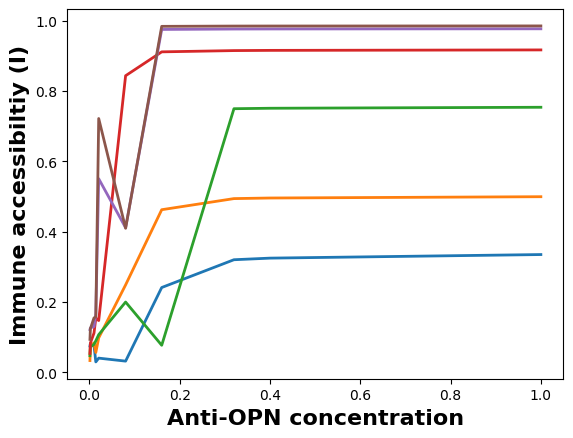

In [36]:
## Immune accessibility index wrt OPN levels and decreasing LIF levels (Figure No. 8(c))
# Purpose of the study: OPN removal reprograms the TME towards improved response to ICI
FC_TUM_OPN=[]
FC_TUM_LIF=[]
I_LIF=[]
C_OPN=[500, 1000, 5000, 7000, 10200, 40000, 80000, 160000, 200000, 500000] # OPN removal rate 
C_LIF=[0, 50, 100, 200, 400, 500] # LIF removal rate
I_OPN=np.empty((len(C_LIF),len(C_OPN)))
Anti_OPN_max=np.max(C_OPN)

for k in range(len(C_LIF)):
    for j in range(len(C_OPN)):
        def solve_stiff_ode_with_params_post_ICI_OPN():
# Initial conditions
            t_span = (0, 70000)
            u = 0
            C_IL2 =0
            c_lif =C_LIF[k]
            C_IL8 = 0
            C_LAC = 0
            c_opn = C_OPN[j]                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, c_opn, P)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_pre, x_pre_OPN = solve_stiff_ode_with_params_post_ICI_OPN()
        nrow,ncol=x_pre_OPN.shape
        I_OPN[k,j]=1-np.tanh(P[19]*alpha*x_pre_OPN[13,ncol-1])
    plt.plot(C_OPN/Anti_OPN_max,I_OPN[k,:], linewidth=2)                                 # Plotting I vs OPN levels for different LIF
    plt.xlabel('Anti-OPN concentration', fontsize=16, fontweight='bold')
    plt.ylabel('Immune accessibiltiy (I)', fontsize=16, fontweight='bold')

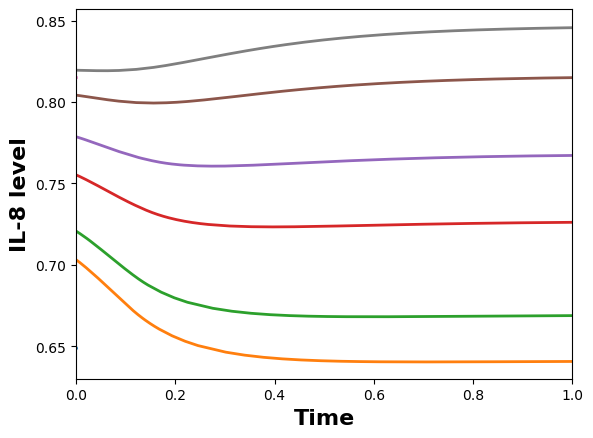

In [37]:
## This code generates the main text figures depicting the prospect of IL-8 as biomarker (Figure 9) 
## Initialisation
y_0=[5.6304, 7.6874, 8.0805, 3.9277, 7.5001, 0.1805, 0.8207, 2.5095, 0, 7.9163, 7.5867, 8.0238, 6.3413, 0.4928, 9.4814, 6.1741, 9.7238, 7.2642, 5.0844, 8.1333, 7.8140, 1.8921, 0.9877, 5.9869] # initial point

##  IL-8 vs time (Figure No.- 9(a))
# Purpose of the study: Increase in post-ICI IL-8 can be a potential marker of possible (Non-)response affected by fibro-rich environment

alpha=[0.005, 0.08, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5] # Different accessibility rate
tspan=[0, 70000]
I=[]
anti_PD1=2  #ICI
Y_CAN=30000 # Carrying capacity of tumor cells
Y_CAF=5000  # Carrying capacity of CAF
Y_M2=5000   # Carrying capacity of M2 macrophage
Y_T=5000    # Carrying capacity of Killer T cells
IL_8D=5     # IL-8 degradation rate
IL8_MAX=(2*Y_CAN+2*Y_CAF+15*Y_M2)/IL_8D  # Calculating maximum IL-8 concentration. 2,2,15 are the IL8-secretion rates of tumor cells, CAF, and M2 macrophages respectively

for j in range(len(alpha)):
    P=HNSCC_parameters(alpha[j])
    def solve_stiff_ode_with_params_pre_ICI_IL8():
# Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI_IL8()
    nrow,ncol=x_pre.shape
    I_1=100*(1-np.tanh(P[19]*alpha[j]*x_pre[13,ncol-1]))
    I.append(I_1)
    def solve_stiff_ode_with_params_post_ICI_IL8():
# Initial conditions
        y_01=x_pre[:,ncol-1]
        t_span = (0, 70000)
        u = 2
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                   
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI_IL8()
    plt.plot(t_post,x_post[19,:]/IL8_MAX, linewidth=2)
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('IL-8 level', fontsize=16, fontweight='bold')
    plt.xlim([0,1])
plt.show()

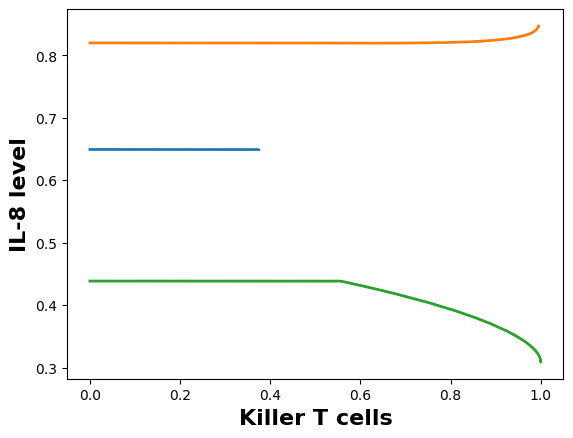

In [38]:
## IL-8 for different TME subtypes (Figure No.- 9(b))
# Purpose of the study: IL-8 can be a distinguishing factor between
# different TME subtypes

alpha=[0.005, 0.5]
for k in range(len(alpha)):
    P=HNSCC_parameters(alpha[k])
    def solve_stiff_ode_with_params_pre_ICI_IL8():
# Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI_IL8()
    nrow,ncol=x_pre.shape
    def solve_stiff_ode_with_params_post_ICI_IL8():
# Initial conditions
        y_01=x_pre[:,ncol-1]
        t_span = (0, 70000)
        u = 2
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                   
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post_ICI_IL8()
    x_post[x_post<0]=0
    plt.plot(x_post[8,:]/Y_T,x_post[19,:]/IL8_MAX, linewidth=2)    # Plotting IL-8 vs. T cells for immune and fibro rich
    plt.xlabel('Killer T cells', fontsize=16, fontweight='bold')
    plt.ylabel('IL-8 level', fontsize=16, fontweight='bold')    

y_0FD=[2000, 0, 2500, 4000, 0, 0, 59.8564, 50, 0, 40, 20, 30, 150, 150, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 0, 13.7578]
alpha=0.005
P=HNSCC_parameters_fibro_desert_modelling(alpha);
P[15]=1500;
def solve_stiff_ode_with_params_pre_ICI_IL8():
# Initial conditions
    t_span = (0, 70000)
    u = 0
    C_IL2 =0
    C_LIF =0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0FD, method='BDF')
    return solution.t, solution.y
t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI_IL8()
nrow,ncol=x_pre.shape
def solve_stiff_ode_with_params_post_ICI_IL8():
# Initial conditions
    y_01=x_pre[:,ncol-1]
    t_span = (0, 70000)
    u = 2
    C_IL2 =0
    C_LIF =0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                   
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
    return solution.t, solution.y
t_post, x_post = solve_stiff_ode_with_params_post_ICI_IL8()

plt.plot(x_post[8,:]/Y_T,x_post[19,:]/IL8_MAX, linewidth=2) # Plotting IL8 vs T cells for fibro desert
plt.show()

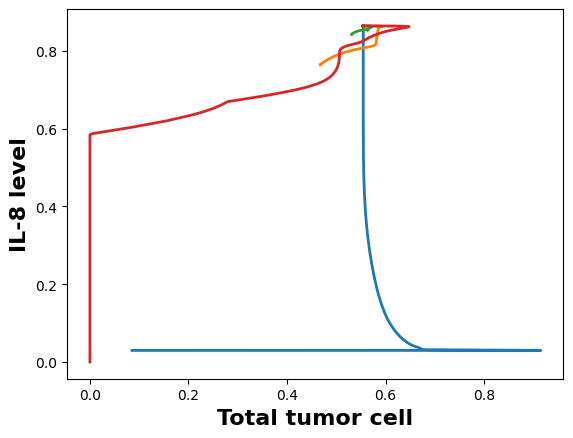

In [39]:
## Effect of OPN+LIF knockout on IL-8 levels (Figure No.- 9(c))

y_0=[108.2087, 602.6678, 350.1559, 937.5152, 556.5256, 33.2473, 888.2395, 244.3348, 0, 722.0367, 78.8519, 697.2312, 793.8480, 450.4767, 541.5014, 253.9598, 961.2047, 294.3169, 172.0025, 859.1064, 766.1546, 641.7523, 484.2232, 132.2313]
C_LIF=[0, 500000000]
C_OPN=[0, 500000000]
alpha=0.5
P=HNSCC_parameters_OPN(alpha)
IL_8_Residue=[]
def solve_stiff_ode_with_params_pre_ICI_IL8():
# Initial conditions
    t_span = (0, 70000)
    u = 0
    C_IL2 =0
    C_LIF =0
    C_IL8 = 0
    C_LAC = 0
    C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
    return solution.t, solution.y
t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI_IL8()
nrow,ncol=x_pre.shape
y_01=x_pre[:,ncol-1]

def solve_stiff_ode_with_params_post_ICI_IL8_OPN_KO():
# Initial conditions
    t_span = (0, 70000)
    u = 2
    C_IL2 =0
    c_lif =C_LIF[0]
    C_IL8 = 0
    C_LAC = 0
    c_opn = C_OPN[1]                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, c_opn, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
    return solution.t, solution.y
t_post_OPN_KO, x_post_OPN_KO = solve_stiff_ode_with_params_post_ICI_IL8_OPN_KO()

def solve_stiff_ode_with_params_post_ICI_IL8_LIF_KO():
# Initial conditions
    t_span = (0, 70000)
    u = 2
    C_IL2 =0
    c_lif =C_LIF[1]
    C_IL8 = 0
    C_LAC = 0
    c_opn = C_OPN[0]                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, c_opn, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
    return solution.t, solution.y
t_post_LIF_KO, x_post_LIF_KO = solve_stiff_ode_with_params_post_ICI_IL8_LIF_KO()
P[48]=0
P[54]=0
def solve_stiff_ode_with_params_post_ICI_IL8_OPN_LIF_KO():
# Initial conditions
    t_span = (0, 70000)
    u = 2
    C_IL2 =0
    c_lif =C_LIF[1]
    C_IL8 = 0
    C_LAC = 0
    c_opn = C_OPN[1]                    
# Define a lambda function to pass parameters to the ODE system
    ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, c_opn, P)

# Solve the ODE using the BDF method
    solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
    return solution.t, solution.y
t_post_OPN_LIF_KO, x_post_OPN_LIF_KO = solve_stiff_ode_with_params_post_ICI_IL8_OPN_LIF_KO()
x_post_OPN_LIF_KO[x_post_OPN_LIF_KO<0]=0

plt.plot(np.sum(x_pre[:5,:], axis=0)/Y_CAN,x_pre[19,:]/IL8_MAX, linewidth=2)    # Plotting IL-8 vs tumor cells in fibro-rich condition
plt.xlabel('Total tumor cell', fontsize=16, fontweight='bold')
plt.ylabel('IL-8 level', fontsize=16, fontweight='bold')
plt.plot(np.sum(x_post_OPN_KO[:5,:],axis=0)/Y_CAN,x_post_OPN_KO[19,:]/IL8_MAX, linewidth =2 ) # Plotting IL-8 vs tumor cells With LIF knockout
plt.plot(np.sum(x_post_LIF_KO[:5,:],axis=0)/Y_CAN,x_post_LIF_KO[19,:]/IL8_MAX, linewidth = 2) # Plotting IL-8 vs tumor cells With OPN knockout
plt.plot(np.sum(x_post_OPN_LIF_KO[:5,:],axis=0)/Y_CAN,x_post_OPN_LIF_KO[19,:]/IL8_MAX, linewidth= 2) # Plotting IL-8 vs tumor cells With both OPN+LIF knockout

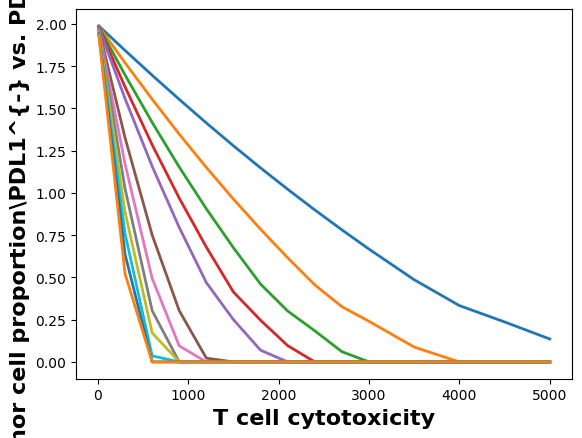

In [40]:
## This code generates the figure depicting the role of Lactate as biomarker and theraputic target (Figure 10)

## Initialisation 
alpha=0.005  # Immune accessibility
P=HNSCC_parameters(alpha);
K_Lac=100
P[17]=K_Lac
Q=P
tspan=[0,70000]
K_TKC=[10, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3500, 4000, 4500, 5000] # Cytotoxic activity for killer T cells
Tum_cell_balance=[] # Ratio from PDL1-ve to +ve tumor cells
C_Lac1=np.arange(0,10,2)
C_Lac2=np.arange(15,50,5)
C_Lac=np.concatenate((C_Lac1, C_Lac2))
Lac_ST=[]
#K_Lac=100;

## Proportion of tumor cells wrt different cytotoxic activity for Lac inhibition rate: Lactate as target (Figure No. 10(a-b))
# 1)Purpose of the study:Lac reprograms the PDL1-/PDL1+ tumor cell ratio towards PDL1- tumor cells

for m in range(len(C_Lac)):
    y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578]  # Initial condition
    Tum_cell_balance=[]
    for l in range(len(K_TKC)):
        Q[15]=K_TKC[l]
        def solve_stiff_ode_with_params_pre():
# Initial conditions
            t_span = (0, 70000)
            u = 0
            C_IL2 =0
            C_LIF =0
            C_IL8 = 0
            c_lac = C_Lac[m]
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, c_lac, C_OPN, P)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_pre, x_pre = solve_stiff_ode_with_params_pre()
        nrow,ncol=x_pre.shape        
        y_0=x_pre[:,ncol-1]
        TCB=(x_pre[0,ncol-1]+x_pre[2,ncol-1])/x_pre[3,ncol-1] # Calculating the PDL1-/PDL1+ tumor cell proportion
        Tum_cell_balance.append(TCB)
    plt.plot(K_TKC, Tum_cell_balance, linewidth=2)
    plt.xlabel('T cell cytotoxicity', fontsize=16, fontweight='bold')
    plt.ylabel('Tumor cell proportion\\PDL1^{-} vs. PDL1{+}', fontsize=16, fontweight='bold')        
plt.show()

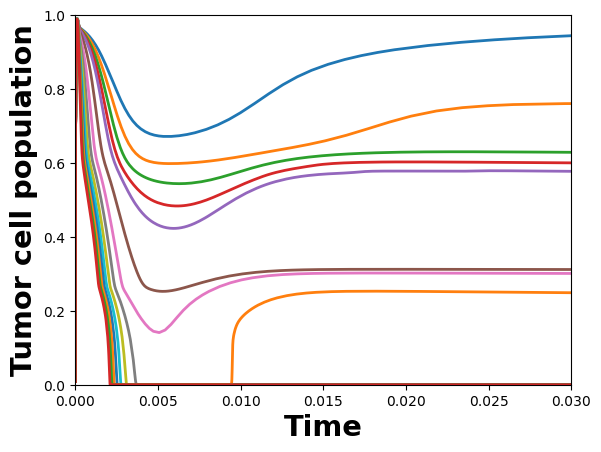

In [41]:
C_Lac1=np.arange(0,900,200)
C_Lac2=np.arange(1500,10**4,1000)
C_LAC=np.concatenate((C_Lac1, C_Lac2))
P=HNSCC_parameters(alpha);
K_TKC=1500;
K_Lac=100;
P[16]=K_Lac
P[15]=K_TKC
anti_PD1=1
for m in range(len(C_LAC)):
    y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition
    def solve_stiff_ode_with_params_post():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        c_lac = C_LAC[m]
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, c_lac, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post()
    plt.plot(t_post,np.sum(x_post[:5,:],axis=0)/30000, linewidth=2) # Plotting tumor cell balance vs. T-cell cytotoxicity levels
    plt.xlabel('Time', fontsize=20.8, fontweight='bold')
    plt.ylabel('Tumor cell population', fontsize=20.8, fontweight='bold')    
    plt.xlim([0,0.03])
    plt.ylim([0,1])
plt.show()    


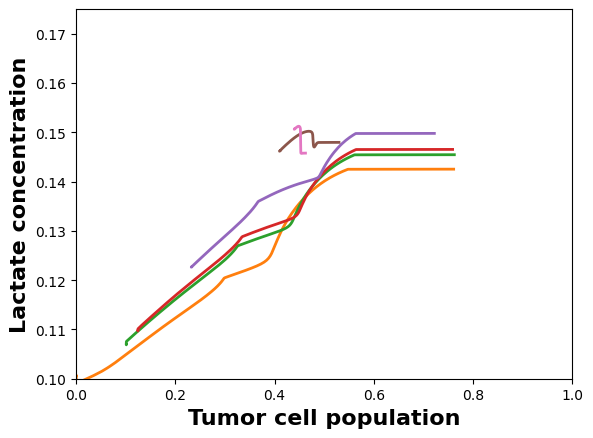

In [42]:
## Lac vs tumor cells for different accessibility (Figure No. 10(c))
#Purpose of the study: Lactate as a biomarker
y_0=[1089.2, 4820.3, 3302.5, 4106.2, 2576.4, 0990.7, 1340.2, 4718.3, 0, 4673.2, 2045.2, 684.8, 502.5, 797.0, 2504.0, 4912.0, 2114.7, 1753.9, 1601.0, 4659.6, 4097.4, 663.8, 3277.8, 732.9] # Initial condition
alpha1=[0.01, 0.02, 0.04, 0.05, 0.1, 0.3, 0.5] # Fraction of CAFs engadged in building the barrier
Y_LAC=22531 # Maximum LAC Carrying capacity. Can be calculated from the equation describing LIF dynamics
I=[]
for l in range(len(alpha1)):
    P=HNSCC_parameters(alpha1[l])
    def solve_stiff_ode_with_params_pre():
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre()
    nrow,ncol=x_pre.shape        
    y_01=x_pre[:,ncol-1]
    def solve_stiff_ode_with_params_post():
# Initial conditions
        t_span = (0, 70000)
        u = 1
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_01, method='BDF')
        return solution.t, solution.y
    t_post, x_post = solve_stiff_ode_with_params_post()
    I_1= (1-np.tanh(alpha1[l]*P[19]*x_pre[13,ncol-1]))*100 #Calculating Immune accessibility index
    I.append(I_1)
    plt.plot(np.sum(x_post[:5,:],axis=0)/30000,x_post[20,:]/Y_LAC,linewidth=2)
    plt.xlabel('Tumor cell population', fontsize=16, fontweight='bold')
    plt.ylabel('Lactate concentration', fontsize=16, fontweight='bold')
    plt.xlim([0,1])
    plt.ylim([0.1,0.175])
plt.show()

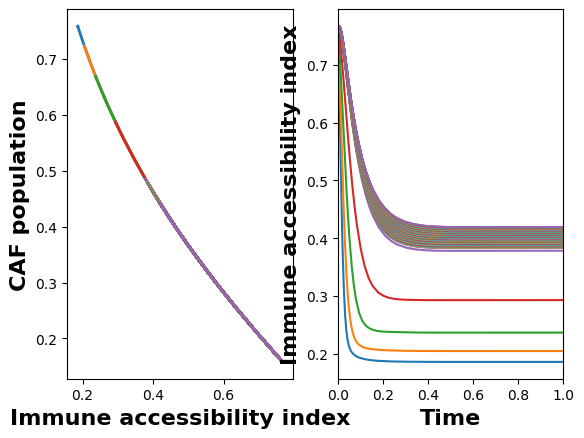

In [43]:
## This MATLAB code simulates the model for different levels of immune accessibility (Fig S5)
## Purpose of the study: To evaluate how the CAF dynamics modulates the immune accessibility (I_a) over time- sudden/ gradual change in I_a over time  
alpha=0.3
K_P_CAF1=np.arange(0,1,0.1)
K_P_CAF2=np.arange(1.1,10.1,2)
K_P_CAF1=np.arange(0,1,0.01)
K_P_CAF=np.concatenate((K_P_CAF1, K_P_CAF2))
P=HNSCC_parameters(0.3)
P[10]=20;
y_0=[1089.2, 4820.3, 3302.5, 4106.2, 2576.4, 0990.7, 1340.2, 4718.3, 0, 4673.2, 2045.2, 684.8, 502.5, 797.0, 2504.0, 4912.0, 2114.7, 1753.9, 1601.0, 4659.6, 4097.4, 663.8, 3277.8, 732.9]
for l in range(len(K_P_CAF)):
    P[48]=K_P_CAF[len(K_P_CAF)-l-1]
    P[47]=0.01
    def solve_stiff_ode_with_params_pre():
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod_Res_Comp(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre()
    I=(1-np.tanh(alpha*P[19]*x_pre[13,:]))
    plt.subplot(1,2,1)
    plt.plot(I,x_pre[13,:]/5000, linewidth=2)
    plt.xlabel('Immune accessibility index',fontsize=16, fontweight='bold')
    plt.ylabel('CAF population', fontsize=16, fontweight='bold')
    plt.subplot(1,2,2)
    plt.plot(t_pre,I)
    plt.xlabel('Time',fontsize=16, fontweight='bold')
    plt.ylabel('Immune accessibility index', fontsize=16, fontweight='bold')
    plt.xlim([0,1])
plt.show()

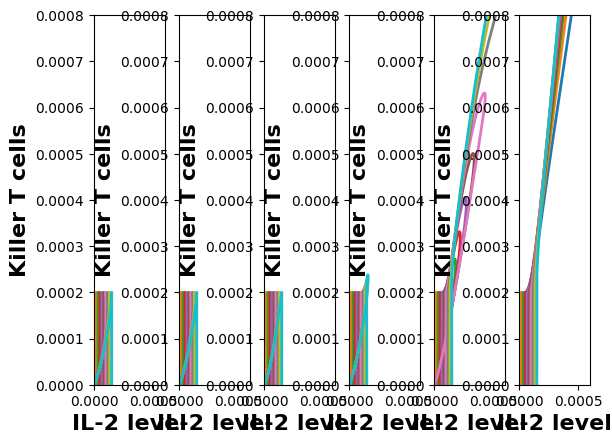

In [44]:
## This code generates the supplementary figures depicting the effects of IL-2 (Supplementary Figure 6)
## Initialisation
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 1, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 0, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition
C_IL2=np.arange(0,2,0.5) 
C_IL21=np.arange(2.05,3,0.02)       # IL-2 levels
C_IL2_A=np.concatenate((C_IL2, C_IL21))
alpha=0.005 # Fixing the immune accessibility
P=HNSCC_parameters_IL2(alpha) # Loading the parameters
tspan=[0,70000]
anti_PD1=1;
K_IL2TK=np.array([0.5, 1, 2, 3, 4, 5])
IL_2U=np.arange(0,1,0.1) # Initial IL-2

for K in range(len(K_IL2TK)):
    P[37]=K_IL2TK[K]
    for L in range(len(IL_2U)):
        y_0[16]=IL_2U[L]
        def solve_stiff_ode_with_params_post():
# Initial conditions
            t_span = (0, 70000)
            u = 1
            C_IL2 =0
            C_LIF =0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
            return solution.t, solution.y
        t_post, x_post = solve_stiff_ode_with_params_post()
        plt.subplot(1,len(K_IL2TK),K+1)
        plt.plot(x_post[16,:]/6000,x_post[8,:]/5000, linewidth=2)
        plt.xlabel('IL-2 level',fontsize=16, fontweight='bold')
        plt.ylabel('Killer T cells',fontsize=16, fontweight='bold')
        plt.ylim([0, 0.0008]) # For the inset
        plt.xlim([0,0.0006])

plt.show()

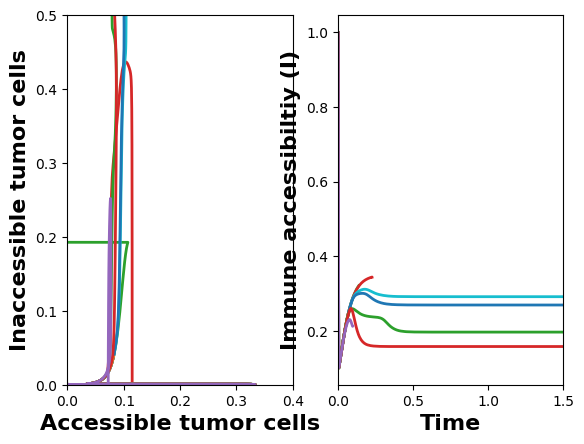

In [45]:
## This code generates the supplementary text figures concerning LIF Knockout (Figure S7)

## Initialisation
y_0=[5.6304, 7.6874, 8.0805, 3.9277, 7.5001, 0.1805, 0.8207, 2.5095, 0, 7.9163, 7.5867, 8.0238, 6.3413, 0.4928, 9.4814, 6.1741, 9.7238, 7.2642, 5.0844, 8.1333, 7.8140, 1.8921, 0.9877, 5.9869] # Initialisation
tspan=[0, 70000]
C_LIF=np.array([0, 50, 100, 150, 200, 250, 300, 350, 500, 650, 800, 1000, 1500, 5000, 15000000]) # LIF-removal rate
anti_PD1=2 # ICI 
alpha=0.3 # Fraction of CAF blocking T cells

## Effect of OPN removal (with or without LIF) (Figure No. 8(a-b))
P=HNSCC_parameters_OPN(alpha)
CAN_ACC_Tot=[]  # Total accessible tumor cells
CAN_IACC_Tot=[] # Total inaccessible tumor cells

for k in range(len(C_LIF)):
    def solve_stiff_ode_with_params_pre():
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        c_lif =C_LIF[len(C_LIF)-k-1]
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, C_OPN, P)
# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre()
    CAN_ACC_Tot=np.add(x_pre[0,:],np.add(x_pre[2,:],x_pre[3,:]))
    CAN_IACC_Tot=np.add(x_pre[1,:],np.add(x_pre[4,:],x_pre[5,:]))
    plt.subplot(1,2,1)
    plt.plot(CAN_ACC_Tot/30000,CAN_IACC_Tot/30000, linewidth=2) # Plotting the propotion of accessible vs inaccessible tumor cells for anti-LIF
    plt.xlabel('Accessible tumor cells', fontsize=16, fontweight='bold')
    plt.ylabel('Inaccessible tumor cells', fontsize=16, fontweight='bold')
    plt.xlim([0,0.4])
    plt.ylim([0,0.5])

## Immune accessibility index wrt OPN levels and decreasing LIF levels (Figure No. 8(c))
# Purpose of the study: OPN removal reprograms the TME towards improved response to ICI
I_LIF=[]

for k in range(len(C_LIF)):
    def solve_stiff_ode_with_params_pre():
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        c_lif =C_LIF[len(C_LIF)-k-1]
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, c_lif, C_IL8, C_LAC, C_OPN, P)
# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre()
    I_LIF=1-np.tanh(P[19]*alpha*x_pre[13,:])
    plt.subplot(1,2,2)
    plt.plot(t_pre,I_LIF, linewidth=2)
    plt.xlabel('Time', fontsize=16, fontweight='bold')
    plt.ylabel('Immune accessibiltiy (I)', fontsize=16, fontweight='bold')
    plt.xlim([0, 1.5])
plt.show()

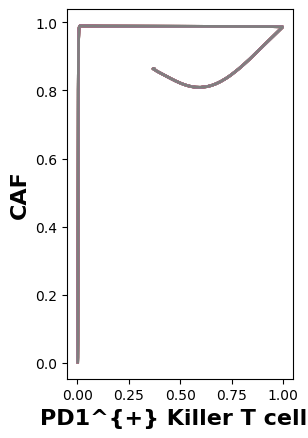

In [46]:
## This code generates the Supplementary plots corresponding to the Immune Rich TME subtype (S2 and S3) in resource-competition setting
## Initialisation
y_0=[22.0447, 6.1926, 17.8158, 201.5737, 5.0551, 6.3483, 59.8564, 7.3397, 0, 8.5270, 4.4444, 0.8939, 52.8060, 15.4442, 18.1709, 13.8821, 4.8854, 19.5717, 13.3581, 10.6108, 12.2203, 10.1635, 16.770, 13.7578] # Initial condition for Simulation
alpha=0.005 # Immune accessibility
Q=[]
P=HNSCC_parameters(alpha);
P[13]=10  # Tuning CAF-C interactions
P[10]=10**2
Q=P.copy()
## Pre ICI: CAF vs Killer T cells 
# Purpose of the study: 1.) Demonstrating the Proliferation rate of T cells does not necessarily change the steady state population of CAF
T_KProl=np.concatenate((np.array([0, 0.05]), np.arange(21,75,10))) # Proliferation of killer T cells
L=len(T_KProl)
tspan=[0,70000]
Tk=[]
CAF=[]
Q2=Q.copy()
for k in range(len(T_KProl)):
    Q[29]=T_KProl[k] # Modifying the proliferation rate of T cells
    Q2[29]=T_KProl[L-k-1]
    def solve_stiff_ode_with_params_pre():
        t_span = (0, 70000)
        u = 0
        C_IL2 =0
        C_LIF =0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)
# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre()
    plt.subplot(1,2,1)
    plt.plot(x_pre[7,:]/5000,x_pre[13,:]/5000, linewidth=2)        # CAF vs. Killer T cells (Fig. S2)
    plt.xlabel('PD1^{+} Killer T cells', fontsize=16, fontweight='bold')
    plt.ylabel('CAF', fontsize=16, fontweight='bold')
plt.show()


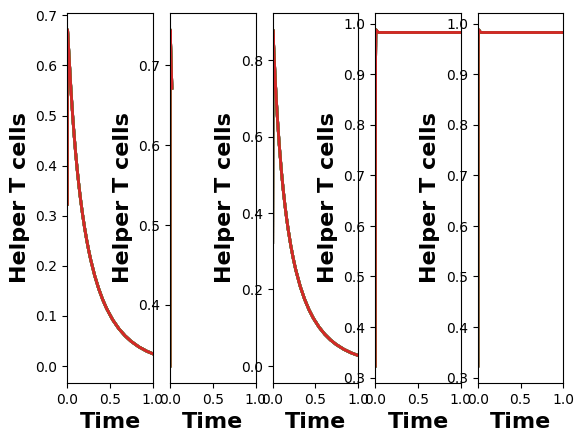

In [47]:
## Simulation of helper T cells for different ration between CAF-Tumor and CAF-Treg for different resource rates (Figure S3)
# Purpose of the study: CAF plays a dual role in regulating the helper T cell population
T_CAF_REG=15
Res=np.arange(1,10,2)
CAF_C_MUL=np.array([0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 5.5, 6, 6.5, 7, 9, 11])
TH=[]
Y_0=[654.8, 354.5, 1227.8, 1997.2, 860.0, 1789.7, 29.3, 704.7, 0, 1615.7, 1287.4, 1536, 1395.2, 222.9, 314, 925.6, 1869.7, 1109.7, 521.1, 1011.7, 1468.4, 1724.2, 429.1, 117]

for k in range(len(Res)):
    P[10]=Res[k]
    Q1=P.copy()
    Q1[38]=150
    Q1[40]=0.001
    for k1 in range(len(CAF_C_MUL)):
        Q1[39]=T_CAF_REG
        Q1[13]=T_CAF_REG*CAF_C_MUL[k1]
        def solve_stiff_ode_with_params_pre():
            t_span = (0, 70000)
            u = 0
            C_IL2 =0
            C_LIF =0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)
# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, Y_0, method='BDF')
            return solution.t, solution.y
        t_pre, x_pre = solve_stiff_ode_with_params_pre()
        plt.subplot(1,len(Res),k+1)
        plt.plot(t_pre, x_pre[9,:]/5000, linewidth=2)        # CAF vs. Killer T cells (Fig. S2)
        plt.xlabel('Time', fontsize=16, fontweight='bold')
        plt.ylabel('Helper T cells', fontsize=16, fontweight='bold')
        plt.xlim([0,1])
plt.show()

<ipython-input-202-fed53bd07286>:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[46]=P[57]*P_46
<ipython-input-202-fed53bd07286>:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[47]=10*P_47
<ipython-input-202-fed53bd07286>:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[48]=10*P_48
<ipython-input-202-fed53bd07286>:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a sing

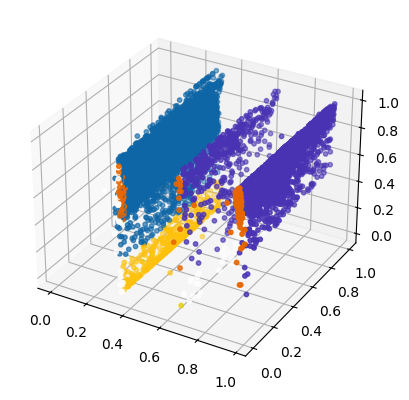

In [202]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import qmc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
n_samples=10000
n_dimensions=24
P_sampler=qmc.LatinHypercube(d=n_dimensions)
P_Para=P_sampler.random(n=n_samples)
P_Para=qmc.scale(P_Para,0,2000)
alpha1=0.02
tspan=[0, 70000]
CAF_ST=[]
T_ST=[]
TUM_ST=[]
n=1
X_ST=[]                                               
X_ST_Post=[]
Tum_Prol_D_Bal=[]                                         
T_Prol_D_Bal=[]                                         
CAF_Prol_D_Bal=[]
P=HNSCC_parameters(alpha1)                         
P[7]=0                                           
P[15]=1500                                       
P[0:5]=P[0:5]/10 
for j in range(0,n_samples-1):
    P[11]=P_Para[j,0]                                      
    P[13]=P_Para[j,1]                                     

    P[29]=0.5*P_Para[j,2]                                  
    P[31]=P_Para[j,3]                                     
    P[32]=P_Para[j,4]                                        
    P[35]=P_Para[j,5]                                     
    P[36]=P_Para[j,6]                                     
    P[37]=P_Para[j,7]                                     
    P[38]=P_Para[j,8]                                     
    P[39]=P_Para[j,9]                                     
    # P(40)=P_para[j,10]
    P[41]=P_Para[j,11]                                    
    P[42]=P_Para[j,12]                                    
    P[43]=P_Para[j,13]                                    
    P[44]=P_Para[j,14]                                    

    P[47]=P_Para[j,15]                                    
    P[48]=P_Para[j,16]                                    
    P[49]=P_Para[j,17]                                    
    P[50]=1+0.005*P_Para[j,18]                            
    P[52]=P_Para[j,20]                                    
    P[53]=P_Para[j,21]                                     
    P[54]=P_Para[j,22]                                   
    P[57]=P_Para[j,23]                                      
    def solve_stiff_ode_with_params():
    # Initial conditions
        y_0=0.5*np.ones(24)
        y_0[8]=0
        t_span = (0, 70000)
        u = 0
        C_IL2=0
        C_LIF=0
        C_IL8=0
        C_LAC=0
        C_OPN = 0
                        
    # Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

    # Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')

        return solution.t, solution.y
    t_points, y_points = solve_stiff_ode_with_params()
    X_ST.append(y_points[:,len(y_points[0])-1])
    T_1=(1+P[11])*(1+P[13])*max(P[0:5])/(P[15]+P[25])
    Tum_Prol_D_Bal.append(T_1)
    T_2=P[29]*(1+P[36])*(1+P[37])/(P[35]+P[41])                  
    T_Prol_D_Bal.append(T_2)
    T_3=P[47]*(1+P[48])*(1+P[49])*(1+P[53])/(P[57]+P[55])
    CAF_Prol_D_Bal.append(T_3)
for k in range(0,1001):
    P[11]=P_Para[k,0]
    P[29]=P_Para[k,1]
    P[31]=P_Para[k,2]
    P[32]=P_Para[k,3]
    P[35]=P_Para[k,4]
    P[36]=P_Para[k,5]
    P[37]=P_Para[k,6]
    P[38]=P_Para[k,7]
    P[39]=P_Para[k,8]
   # P(40)=P_para(9,k);
    P[41]=P_Para[k,10]
    P[42]=P_Para[k,11]
    P[43]=P_Para[k,12]
    P[44]=P_Para[k,13]
    P[57]=P_Para[k,14] 
    P_461=qmc.LatinHypercube(1)
    P_46=P_461.random(1)   
    P[46]=P[57]*P_46                                         
    P_471=qmc.LatinHypercube(1)
    P_47=P_471.random(1)
    P[47]=10*P_47
    P_481=qmc.LatinHypercube(1)
    P_48=P_481.random(1)
    P[48]=10*P_48
    P_491=qmc.LatinHypercube(1)
    P_49=P_491.random(1)
    P[49]=10*P_49
    P_501=qmc.LatinHypercube(1)
    P_50=P_501.random(1)
    P[50]=10*P_50
    #P(51)=P_para(18,k);
    P[52]=P_Para[k,19]
    P_531=qmc.LatinHypercube(1)
    P_53=P_531.random(1)
    P[53]=10*P_53
    P_541=qmc.LatinHypercube(1)
    P_54=P_541.random(1)
    P[54]=10*P_54
    def solve_stiff_ode_with_params_fib_des():
    # Initial conditions
        y_0=0.5*np.ones(24)
        y_0[8]=0
        t_span = (0, 70000)
        u = 0
        C_IL2=0
        C_LIF=0
        C_IL8=0
        C_LAC=0
        C_OPN = 0
                        
    # Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

    # Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')

        return solution.t, solution.y
    t_points_1, y_points_1 = solve_stiff_ode_with_params_fib_des()
    X_ST.append(y_points_1[:,len(y_points_1[0])-1])
    T_11=(1+P[11])*(1+P[13])*max(P[0:5])/(P[15]+P[25])
    Tum_Prol_D_Bal.append(T_11)
    T_22=P[29]*(1+P[36])*(1+P[37])/(P[35]+P[41])                  
    T_Prol_D_Bal.append(T_22)
    T_33=P[47]*(1+P[48])*(1+P[49])*(1+P[53])/(P[57]+P[55])
    CAF_Prol_D_Bal.append(T_33)  

Tum_PD=np.array(Tum_Prol_D_Bal)
TK_PD=np.array(T_Prol_D_Bal)
Tum_PD=np.array(Tum_Prol_D_Bal)
TK_PD=np.array(T_Prol_D_Bal)
CAF_PD=np.array(CAF_Prol_D_Bal)
BAL_PD=np.column_stack((Tum_PD, np.column_stack((TK_PD,CAF_PD))))
X_ST_np=np.array(X_ST)
C_Tum=np.sum(X_ST_np[:,:5],axis=1)/30000
C_TK=X_ST_np[:,7]/5000
C_CAF=X_ST_np[:,13]/5000
ST=np.column_stack((C_Tum, np.column_stack((C_TK, C_CAF))))

L1=np.where(ST[:,0]<0)
BAL_PD=np.delete(BAL_PD, L1, axis=0)
ST=np.delete(ST, L1, axis=0)
L2=np.where(ST[:,0]>1)
BAL_PD=np.delete(BAL_PD, L2, axis=0)
ST=np.delete(ST, L2, axis=0)
L3=np.where(ST[:,1]<0)
BAL_PD=np.delete(BAL_PD, L3, axis=0)
ST=np.delete(ST, L3, axis=0)
L4=np.where(ST[:,1]>1)
BAL_PD=np.delete(BAL_PD, L4, axis=0)
ST=np.delete(ST, L4, axis=0)
L5=np.where(ST[:,2]<0)
BAL_PD=np.delete(BAL_PD, L5, axis=0)
ST=np.delete(ST, L5, axis=0)
L6=np.where(ST[:,2]>1)
BAL_PD=np.delete(BAL_PD, L6, axis=0)
ST=np.delete(ST, L6, axis=0)
nrows, ncols=ST.shape

ST1=ST;
P_Count = np.where((ST[:, 1] > 0.1) & (ST[:, 0] > 0.9) & (ST[:, 2] < 0.5))
ST1=np.delete(ST1, P_Count, axis=0)
nrows,ncols=ST1.shape
C=np.ones((nrows, ncols))
FD_Count=np.where((ST1[:, 0] < 0.6) & (ST1[:, 1] > 0.05) & (ST1[:, 2] < 0.2))
IR_Count=np.where((ST1[:, 0] < 0.6) & (ST1[:, 1] > 0.01) & (ST1[:, 2] > 0.2))
FR_Count=np.where((ST1[:, 0] > 0.6) & (ST1[:, 1] > 0.05) & (ST1[:, 2] > 0.2))
ID_Count=np.where((ST1[:, 0] > 0.35) & (ST1[:, 1] < 0.05) & (ST1[:, 2] > 0.1))
D_Count=np.where((ST1[:, 0] > 0.36) & (ST1[:, 1] < 0.05) & (ST1[:, 2] < 0.2))

C[FD_Count,:]=[1, 0.76, 0.05]
C[IR_Count,:]=[0.06, 0.4, 0.65]
C[FR_Count,:]=[0.285, 0.2, 0.7]
C[ID_Count,:]=[0.9, 0.4, 0]
C[D_Count,:]=[0.9, 0.8, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ST1[:,0], ST1[:,1], ST1[:,2], s=10, c=C, marker='o')
plt.show()

#Tum_PD=np.array(Tum_Prol_D_Bal)
#TK_PD=np.array(T_Prol_D_Bal)
#CAF_PD=np.array(CAF_Prol_D_Bal)
#Bal_PD=np.column_stack(Tum_PD,TK_PD,CAF_PD)


In [29]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import qmc
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
num_samples = 10000                                       # number of parameter samples 
alpha1=0.05                                               # Operating in moderate to high immune accessibility scenario.
Y_RM=10**3
P=HNSCC_parameters(alpha1)                                # Load the nominal parameter values
P[7]=0                                                    # No space competition
P[15]=1500                                                # Toxicity of killer T cells: moderate to high
P[0:5]=P[0:5]/10                                          # Setting up the nominal natural proliferation rates for the tumor cells
P[10]=Y_RM
P_Para=[]
Para_ID=[11, 13, 29, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 52, 53, 54, 57] # Contains the ids of influential parameters
y_0=5*np.ones(24)
y_0[8]=0                               # Uniform initial condition
anti_PD1=2
tspan=[0,70000]                        # Simulation time
CAF_ST=[]
T_ST=[]
TUM_ST=[]
n=1
X_ST=[]                                                   # Stores the pre-ICI final population for Tumor cells, killer T cells, and CAF 
X_ST_Post=[]                                             # Stores the pre-ICI final population for Tumor cells, killer T cells, and CAF 
CAF_ST_Post=[]
TUM_ST_Post=[]
T_ST_Post=[]
for k in range(len(Para_ID)):
    sampler=qmc.LatinHypercube(1)
    para=sampler.random(n=num_samples)
    P1=P[Para_ID[k]]/3+(3*P[Para_ID[k]]-P[Para_ID[k]]/3)*para
    P_Para.append(P1)
P_Para=np.array(P_Para)
nrow,ncol,nmat=P_Para.shape
for j in range(ncol):
    for k1 in range(len(Para_ID)):
        P[Para_ID[k1]]=P_Para[k1,j]
    P[11]=0.15*P[11]
    def solve_stiff_ode_with_params_pre_ICI(): # Initial conditions
        t_span = (0, 70000)
        u = 0
        C_IL2 = 0
        C_LIF = 0
        C_IL8 = 0
        C_LAC = 0
        C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
        ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
        solution = solve_ivp(ode_func, t_span, y_0, method='BDF')
        return solution.t, solution.y
    t_pre, x_pre = solve_stiff_ode_with_params_pre_ICI()
    nrow_pre, ncol_pre=x_pre.shape
    TUM_1=np.sum(x_pre[:5,len(x_pre[0])-1])/30000
    CAF_1=x_pre[13,len(x_pre[0])-1]/5000
    TK_1=x_pre[7,len(x_pre[0])-1]/5000
    
    if TUM_1 <= 0.6 and CAF_1 > 0.2 and TK_1 > 0.01:
        X_ST.append(x_pre[:,len(x_pre[0])-1])
        
        def solve_stiff_ode_with_params_post_ICI():
            # Initial conditions
            y0=x_pre[:,len(x_pre[0])-1]
            t_span = (0, 70000)
            u = 1
            C_IL2 = 0
            C_LIF = 0
            C_IL8 = 0
            C_LAC = 0
            C_OPN = 0                    
# Define a lambda function to pass parameters to the ODE system
            ode_func = lambda t, y: HNSCC_mod(t, y, u, C_IL2, C_LIF, C_IL8, C_LAC, C_OPN, P)

# Solve the ODE using the BDF method
            solution = solve_ivp(ode_func, t_span, y0, method='BDF')
            return solution.t, solution.y
        t_post, x_post = solve_stiff_ode_with_params_post_ICI()
        nrow_post, ncol_post=x_post.shape
        X_ST_Post.append(x_post[:,len(x_post[0])-1])

<ipython-input-29-fc1255c8e913>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[Para_ID[k1]]=P_Para[k1,j]


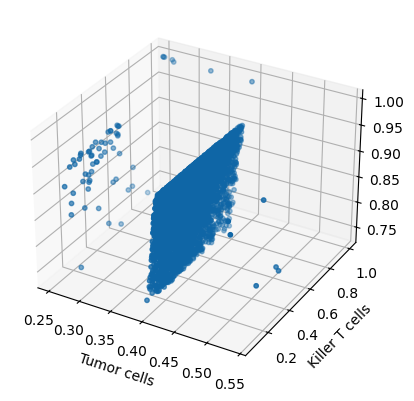

In [42]:
X_ST_np=np.array(X_ST)
C_Tum=np.sum(X_ST_np[:,:5],axis=1)/30000
C_TK=X_ST_np[:,7]/5000
C_CAF=X_ST_np[:,13]/5000
ST=np.column_stack((C_Tum, np.column_stack((C_TK, C_CAF))))

X_ST_Post_np=np.array(X_ST_Post)
C_Tum_Post=np.sum(X_ST_Post_np[:,:5],axis=1)/30000
C_TK_Post=X_ST_Post_np[:,8]/5000
C_CAF_Post=X_ST_Post_np[:,13]/5000
ST_Post=np.column_stack((C_Tum_Post, np.column_stack((C_TK_Post, C_CAF_Post))))

L1=np.where(ST[:,0]<0)
ST=np.delete(ST, L1, axis=0)
ST_Post=np.delete(ST_Post, L1, axis=0)
L2=np.where(ST[:,0]>1)
ST=np.delete(ST, L2, axis=0)
ST_Post=np.delete(ST_Post, L2, axis=0)
L3=np.where(ST[:,1]<0)
ST=np.delete(ST, L3, axis=0)
ST_Post=np.delete(ST_Post, L3, axis=0)
L4=np.where(ST[:,1]>1)
ST=np.delete(ST, L4, axis=0)
ST_Post=np.delete(ST_Post, L4, axis=0)
L5=np.where(ST[:,2]<0)
ST=np.delete(ST, L5, axis=0)
ST_Post=np.delete(ST_Post, L5, axis=0)
L6=np.where(ST[:,2]>1)
ST=np.delete(ST, L6, axis=0)
ST_Post=np.delete(ST_Post, L6, axis=0)
nrows, ncols=ST.shape

ST1=ST;
P_Count = np.where((ST[:, 1] > 0.1) & (ST[:, 0] > 0.9) & (ST[:, 2] < 0.5))
ST1=np.delete(ST1, P_Count, axis=0)
nrows,ncols=ST1.shape
C=np.ones((nrows, ncols))
FD_Count=np.where((ST1[:, 0] < 0.6) & (ST1[:, 1] > 0.05) & (ST1[:, 2] < 0.2))
IR_Count=np.where((ST1[:, 0] < 0.6) & (ST1[:, 1] > 0.01) & (ST1[:, 2] > 0.2))
FR_Count=np.where((ST1[:, 0] > 0.6) & (ST1[:, 1] > 0.05) & (ST1[:, 2] > 0.2))
ID_Count=np.where((ST1[:, 0] > 0.35) & (ST1[:, 1] < 0.05) & (ST1[:, 2] > 0.1))
D_Count=np.where((ST1[:, 0] > 0.36) & (ST1[:, 1] < 0.05) & (ST1[:, 2] < 0.2))

C[FD_Count,:]=[1, 0.76, 0.05]
C[IR_Count,:]=[0.06, 0.4, 0.65]
C[FR_Count,:]=[0.285, 0.2, 0.7]
C[ID_Count,:]=[0.9, 0.4, 0]
C[D_Count,:]=[0.9, 0.8, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ST1[:,0], ST1[:,1], ST1[:,2], s=10, c=C, marker='o')
plt.xlabel('Tumor cells')
plt.ylabel('Killer T cells')

plt.show()


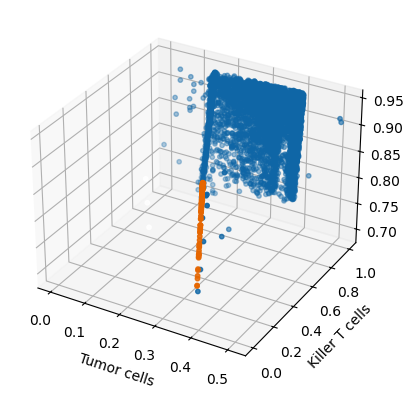

In [41]:
L7=np.where(ST_Post[:,0]<0)
ST_Post=np.delete(ST_Post, L7, axis=0)
L8=np.where(ST_Post[:,0]>1)
ST_Post=np.delete(ST_Post, L8, axis=0)
L9=np.where(ST_Post[:,1]<0)
ST_Post=np.delete(ST_Post, L9, axis=0)
L10=np.where(ST_Post[:,1]>1)
ST_Post=np.delete(ST_Post, L10, axis=0)
L11=np.where(ST_Post[:,2]<0)
ST_Post=np.delete(ST_Post, L11, axis=0)
L12=np.where(ST_Post[:,2]>1)
ST_Post=np.delete(ST_Post, L12, axis=0)

ST2=ST_Post;
P_Count_Post = np.where((ST_Post[:, 1] > 0.1) & (ST_Post[:, 0] > 0.9) & (ST_Post[:, 2] < 0.5))
ST2=np.delete(ST2, P_Count_Post, axis=0)
nrows_Post,ncols_Post=ST2.shape
C1=np.ones((nrows_Post, ncols_Post))
FD_Count_Post=np.where((ST2[:, 0] < 0.6) & (ST2[:, 1] > 0.05) & (ST2[:, 2] < 0.2))
IR_Count_Post=np.where((ST2[:, 0] < 0.6) & (ST2[:, 1] > 0.01) & (ST2[:, 2] > 0.2))
FR_Count_Post=np.where((ST2[:, 0] > 0.6) & (ST2[:, 1] > 0.05) & (ST2[:, 2] > 0.2))
ID_Count_Post=np.where((ST2[:, 0] > 0.35) & (ST2[:, 1] < 0.01) & (ST2[:, 2] > 0.1))
D_Count_Post=np.where((ST2[:, 0] > 0.36) & (ST2[:, 1] < 0.05) & (ST2[:, 2] < 0.2))

C1[FD_Count_Post,:]=[1, 0.76, 0.05]
C1[IR_Count_Post,:]=[0.06, 0.4, 0.65]
C1[FR_Count_Post,:]=[0.285, 0.2, 0.7]
C1[ID_Count_Post,:]=[0.9, 0.4, 0]
C1[D_Count_Post,:]=[0.9, 0.8, 0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ST2[:,0], ST2[:,1], ST2[:,2], s=10, c=C1, marker='o')
plt.xlabel('Tumor cells')
plt.ylabel('Killer T cells')

plt.show()